In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import time

# Paths and stuff
import os
import sys

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

In [2]:
ds_grl40_bm5_paleo17a_CT4_BH0_m21ka_pkp_init = xr.open_dataset('/home/shreyas/update_to_develop_sicopolis/sicopolis_spinups/sico_out/grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka/grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka0005.nc')
surfvel_data_40kms = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/surfvel_data_40kms.nc")
vx_uncert_data = surfvel_data_40kms["vx_uncert"].data
vy_uncert_data = surfvel_data_40kms["vy_uncert"].data

In [3]:
sicopolis_dir = '/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneCS_mini_exact_gamma_delta'
simulation = 'grl40_bm5_paleo17a_nudged_CT4_BH0_SVC_m21ka_pkp'
dict_sico_out_folder_prefixes = {"nodiff": "N",
                                 "tlm": "FORWARD",
                                 "adj": "ADJOINT",
                                 "tlm_action": "FORWARDHESSACTION",
                                 "adj_action": "ADJHESSACTION"}
dict_ad_exec_cmds_suffixes = {"nodiff": "nodiff",
                              "tlm": "forward",
                              "adj": "adjoint",
                              "tlm_action": "forwardhessaction",
                              "adj_action": "adjointhessaction"}
dict_ad_log_file_suffixes = {"nodiff": "nodiff",
                             "tlm": "tlm",
                             "adj": "adj",
                             "tlm_action": "tlm_hessaction",
                             "adj_action": "adj_hessaction"}
dict_ad_nc_suffixes = {"nodiff": "nodiff",
                       "tlm": "tlm",
                       "adj": "adj",
                       "tlm_action": "tlm_hessaction",
                       "adj_action": "adj_hessaction"}

KCMAX = 80
exp_sigma_level = dataCleaner.exp_sigma_level(zeta = np.arange(0,1+1./KCMAX,1./KCMAX),
                                              exponent = 2.0)
KRMAX = 40
zeta_r = np.arange(0.,1. + 1.0/KRMAX, 1.0/KRMAX)
xModel40       = np.arange(-72.,97.,4.0)*10
yModel40       = np.arange(-345.,-56.,4.0)*10
time_ad = np.arange(6, dtype=float)
IMAX = xModel40.shape[0]-1
JMAX = yModel40.shape[0]-1
NTDAMAX = time_ad.shape[0]-1

log_c_slide_init = np.log10(0.85)*np.ones((JMAX+1, IMAX+1))
data = ds_grl40_bm5_paleo17a_CT4_BH0_m21ka_pkp_init['q_geo'].data
log_q_geo = np.where(data > 0, np.log10(data), -10)
log_p_weert = np.log10(3.0)
log_q_weert = np.log10(2.0)
log_enh_fact_da_dummy2d_scalar = np.log10(3.0)
log_enh_intg_da_dummy2d_scalar = np.log10(1.0)
log_n_glen_da_dummy2d_scalar = np.log10(3.0)

# Ensure the sequence in these arrays is the same as defined in ad_specs.h
dict_og_params_fields_vals = {"xx_c_slide_init": log_c_slide_init,
                              "xx_q_geo": log_q_geo,
                              "xx_p_weert": log_p_weert,
                              "xx_q_weert": log_q_weert,
                              "xx_enh_fact_da_dummy2d_scalar": log_enh_fact_da_dummy2d_scalar,
                              "xx_enh_intg_da_dummy2d_scalar": log_enh_intg_da_dummy2d_scalar,
                              "xx_n_glen_da_dummy2d_scalar": log_n_glen_da_dummy2d_scalar}
dict_prior_params_fields_vals = dict_og_params_fields_vals.copy()
dict_params_fields_num_dims = {"xx_c_slide_init": "2D",
                               "xx_q_geo": "2D",
                               "xx_p_weert": "2D",
                               "xx_q_weert": "2D",
                               "xx_enh_fact_da_dummy2d_scalar": "2D",
                               "xx_enh_intg_da_dummy2d_scalar": "2D",
                               "xx_n_glen_da_dummy2d_scalar": "2D"}
dict_params_coords = {"time_ad": time_ad,
                      "zeta_c": exp_sigma_level,
                      "zeta_r": zeta_r,
                      "y": yModel40,
                      "x": xModel40}
dict_params_attrs_type = {"xx_c_slide_init": "nodiff",
                          "xx_q_geo": "nodiff",
                          "xx_p_weert": "nodiff",
                          "xx_q_weert": "nodiff",
                          "xx_enh_fact_da_dummy2d_scalar": "nodiff",
                          "xx_enh_intg_da_dummy2d_scalar": "nodiff",
                          "xx_n_glen_da_dummy2d_scalar": "nodiff"}
dict_params_fields_or_scalars = {"xx_c_slide_init": "field",
                                 "xx_q_geo": "field",
                                 "xx_p_weert": "scalar",
                                 "xx_q_weert": "scalar",
                                 "xx_enh_fact_da_dummy2d_scalar": "scalar",
                                 "xx_enh_intg_da_dummy2d_scalar": "scalar",
                                 "xx_n_glen_da_dummy2d_scalar": "scalar"}

year2sec = 3.1556925445e+07
sec2year = 1/year2sec
dict_masks_observables = {"vx_s_g": (vx_uncert_data*sec2year)**(-2),
                          "vy_s_g": (vy_uncert_data*sec2year)**(-2)}

dict_prior_sigmas = {"xx_c_slide_init": 0.3,
                     "xx_q_geo": 0.3,
                     "xx_p_weert": 0.01,
                     "xx_q_weert": 0.01,
                     "xx_enh_fact_da_dummy2d_scalar": 0.01,
                     "xx_enh_intg_da_dummy2d_scalar": 0.01,
                     "xx_n_glen_da_dummy2d_scalar": 0.01}
dict_prior_gammas = {"xx_c_slide_init": 1.0,
                     "xx_q_geo": 1.0,
                     "xx_p_weert": 0.0,
                     "xx_q_weert": 0.0,
                     "xx_enh_fact_da_dummy2d_scalar": 0.0,
                     "xx_enh_intg_da_dummy2d_scalar": 0.0,
                     "xx_n_glen_da_dummy2d_scalar": 0.0}
dict_prior_deltas = {"xx_c_slide_init": 2.0e-4,
                     "xx_q_geo": 2.0e-4,
                     "xx_p_weert": 1.0,
                     "xx_q_weert": 1.0,
                     "xx_enh_fact_da_dummy2d_scalar": 1.0,
                     "xx_enh_intg_da_dummy2d_scalar": 1.0,
                     "xx_n_glen_da_dummy2d_scalar": 1.0}
                     
list_fields_to_ignore = None

MAX_ITERS_SOR = 100
OMEGA_SOR = 1.5

Pearson correlation y-direction 40 kms:  0.750739604631659
Pearson correlation y-direction 80 kms:  0.5069505140118034
Pearson correlation y-direction 120 kms:  0.34988316678058806
Pearson correlation y-direction 160 kms:  0.2407013114263522
Pearson correlation y-direction 200 kms:  0.17663661069836606
Pearson correlation y-direction 240 kms:  0.11120613591575654
Pearson correlation y-direction 280 kms:  0.07048459047130329
Pearson correlation y-direction 320 kms:  0.05177026813752703
Pearson correlation y-direction 360 kms:  0.03986472667927994
Pearson correlation y-direction 400 kms:  0.025782943791516466
Pearson correlation x-direction 40 kms:  0.7448520974577683
Pearson correlation x-direction 80 kms:  0.4951346037878079
Pearson correlation x-direction 120 kms:  0.32896002837561555
Pearson correlation x-direction 160 kms:  0.22322054798081634
Pearson correlation x-direction 200 kms:  0.11987917743007419
Pearson correlation x-direction 240 kms:  0.07273425021869853
Pearson correlati

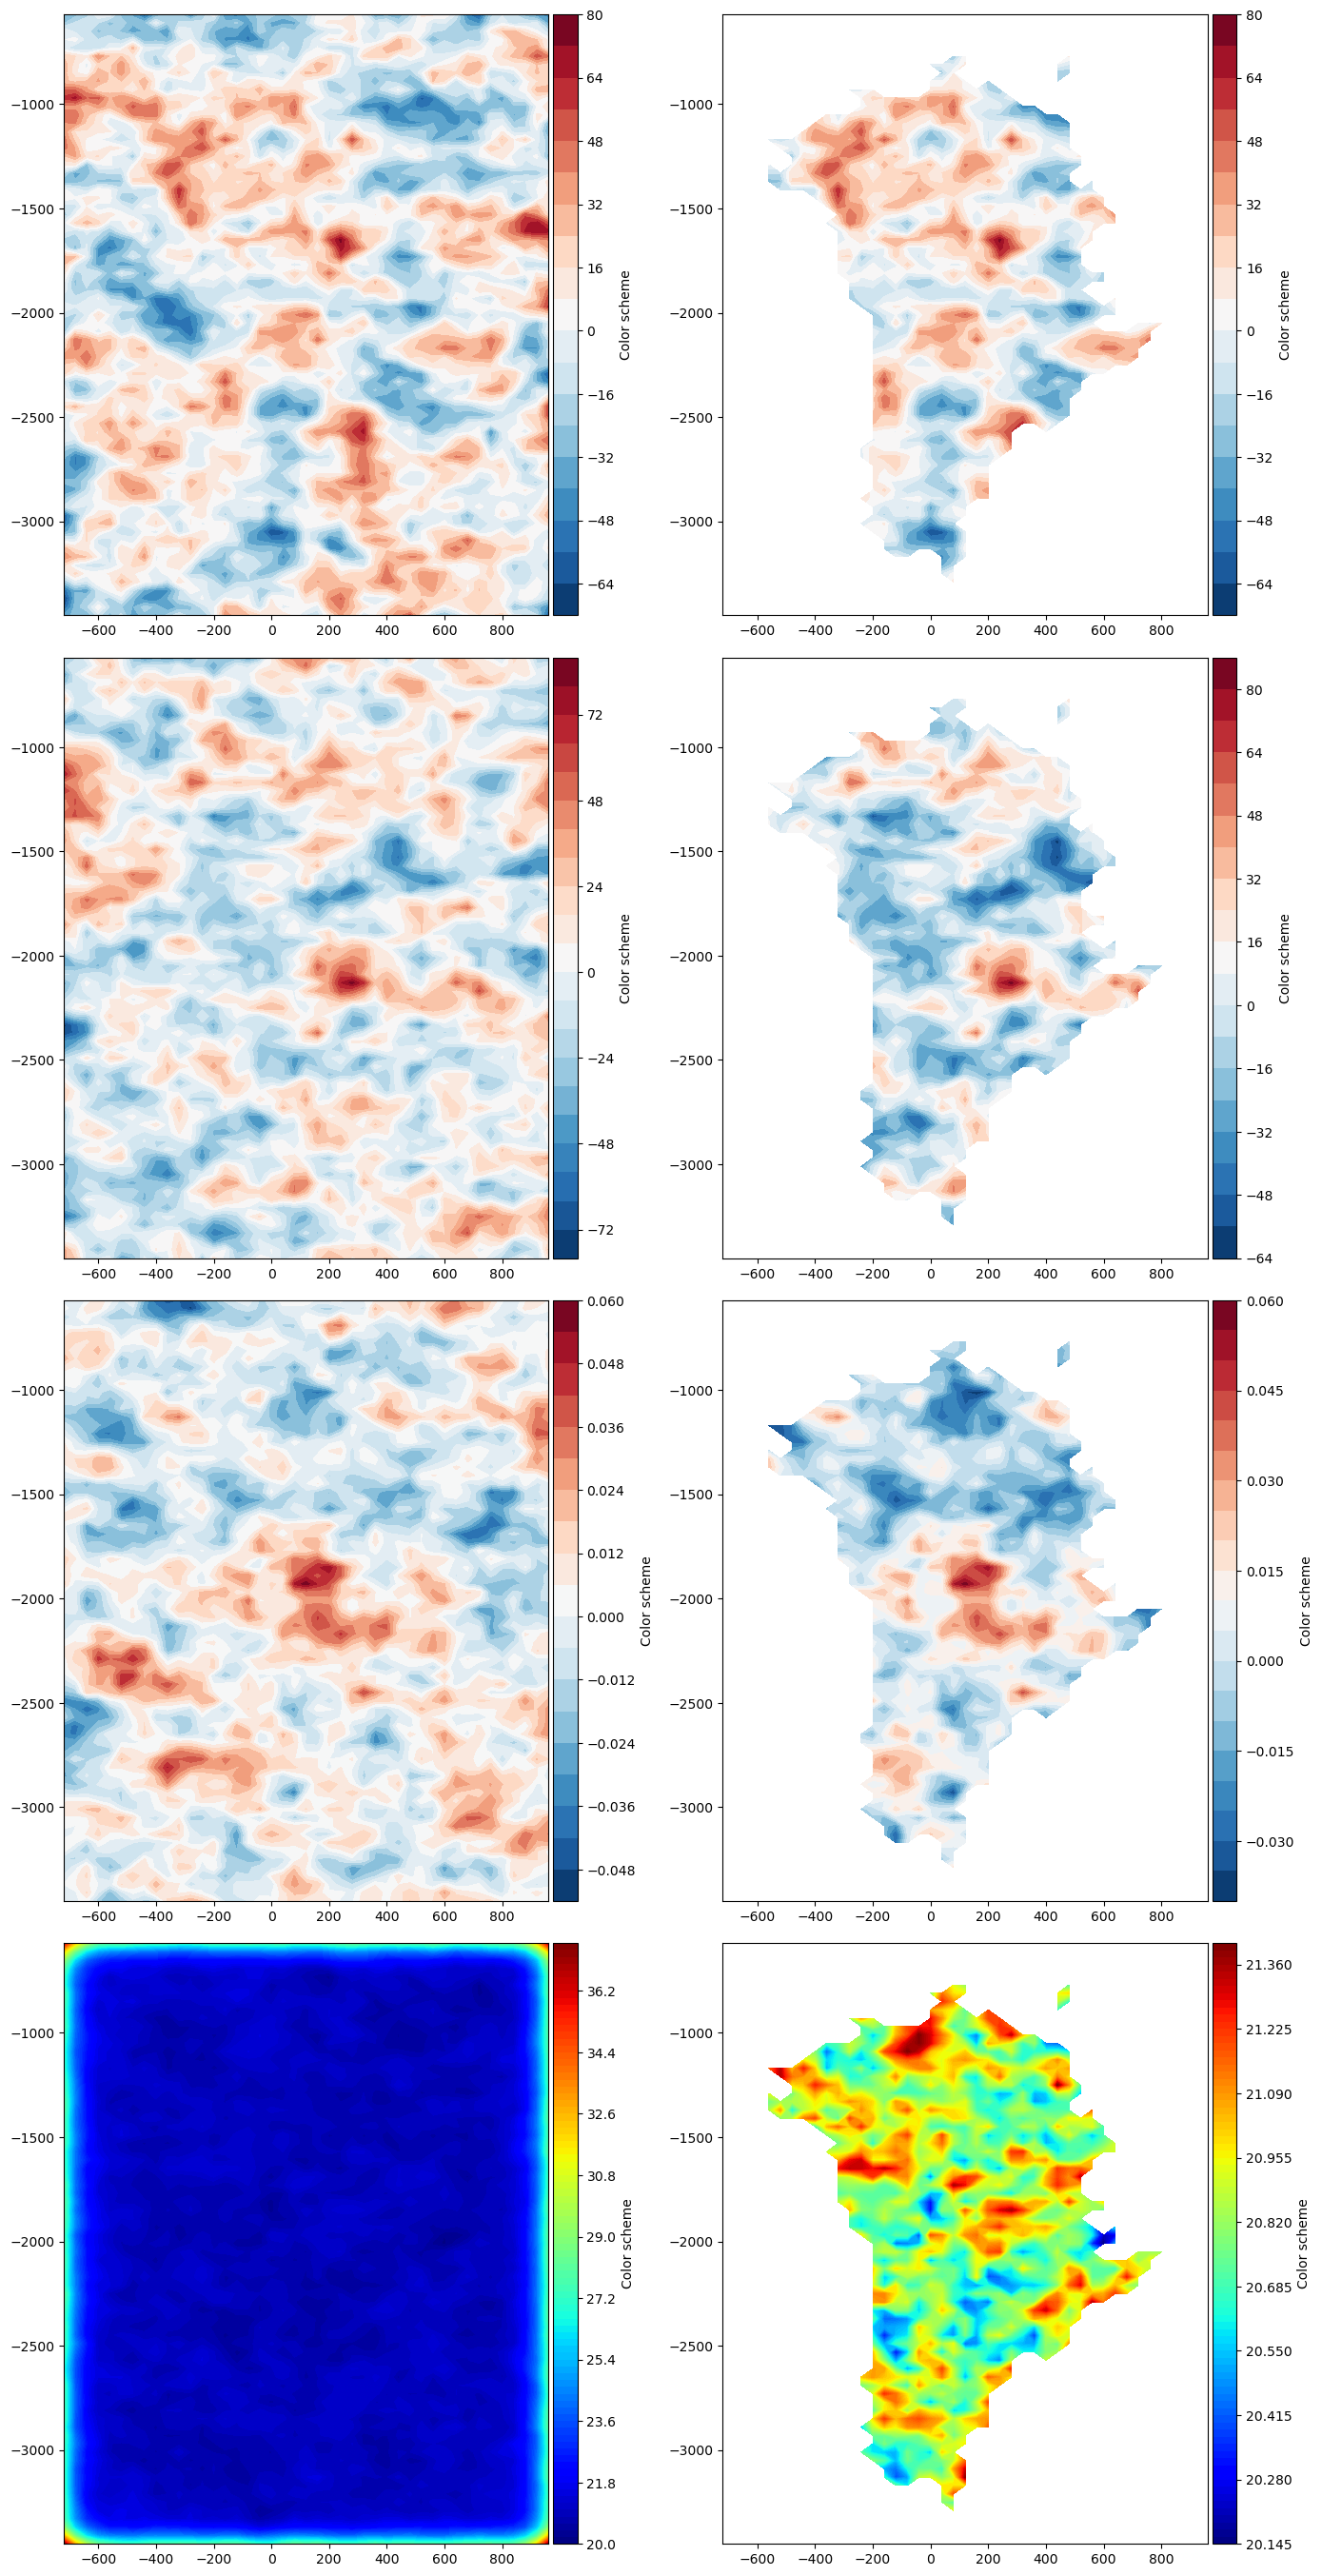

In [4]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_prior_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini_exact_gamma_delta", 5000, None, "0002.nc")

ds_prior_X = DA.ds_prior_X.copy()

ds_subset_sample_prior_C_1 = DA.sample_prior_C()
ds_subset_sample_prior_C_2 = DA.sample_prior_C()
ds_mean_samples_prior_C, ds_std_samples_prior_C = DA.ds_prior_C_mean, DA.ds_prior_C_std

ds_subset_sample_prior_1 = DA.sample_prior()
ds_subset_sample_prior_2 = DA.sample_prior()
ds_mean_samples_prior, ds_std_samples_prior = DA.pointwise_marginals("prior", 5000)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_1["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_2["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior_C["xx_c_slide_initd"].data/ds_std_samples_prior_C["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior_C["xx_c_slide_initd"].data/ds_std_samples_prior_C["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior_C["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior_C["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [5]:
# Example 2D array (replace with your actual 73x43 array)
arr = ds_std_samples_prior_C["xx_c_slide_initd"].data.copy()

# Corners
corners = [arr[0, 0], arr[0, -1], arr[-1, 0], arr[-1, -1]]
mean_corners = np.mean(corners)

# Interior (excluding first/last row and first/last column)
interior = arr[5:-5, 5:-5]
mean_interior = np.mean(interior)
max_interior = np.max(interior)
min_interior = np.min(interior)

# Edges (excluding corners)
top_edge = arr[0, 1:-1]
bottom_edge = arr[-1, 1:-1]
left_edge = arr[1:-1, 0]
right_edge = arr[1:-1, -1]
edges = np.concatenate([top_edge, bottom_edge, left_edge, right_edge])
mean_edges = np.mean(edges)


np.max(ds_std_samples_prior_C["xx_c_slide_initd"].data), \
np.min(ds_std_samples_prior_C["xx_c_slide_initd"].data), \
np.mean(ds_std_samples_prior_C["xx_c_slide_initd"].data), \
mean_corners, mean_edges, mean_interior, max_interior, min_interior

(37.4323086050487,
 20.145436060438588,
 21.766129146884897,
 36.91636021558095,
 27.913214121986243,
 20.863737047822298,
 21.566449679629283,
 20.145436060438588)

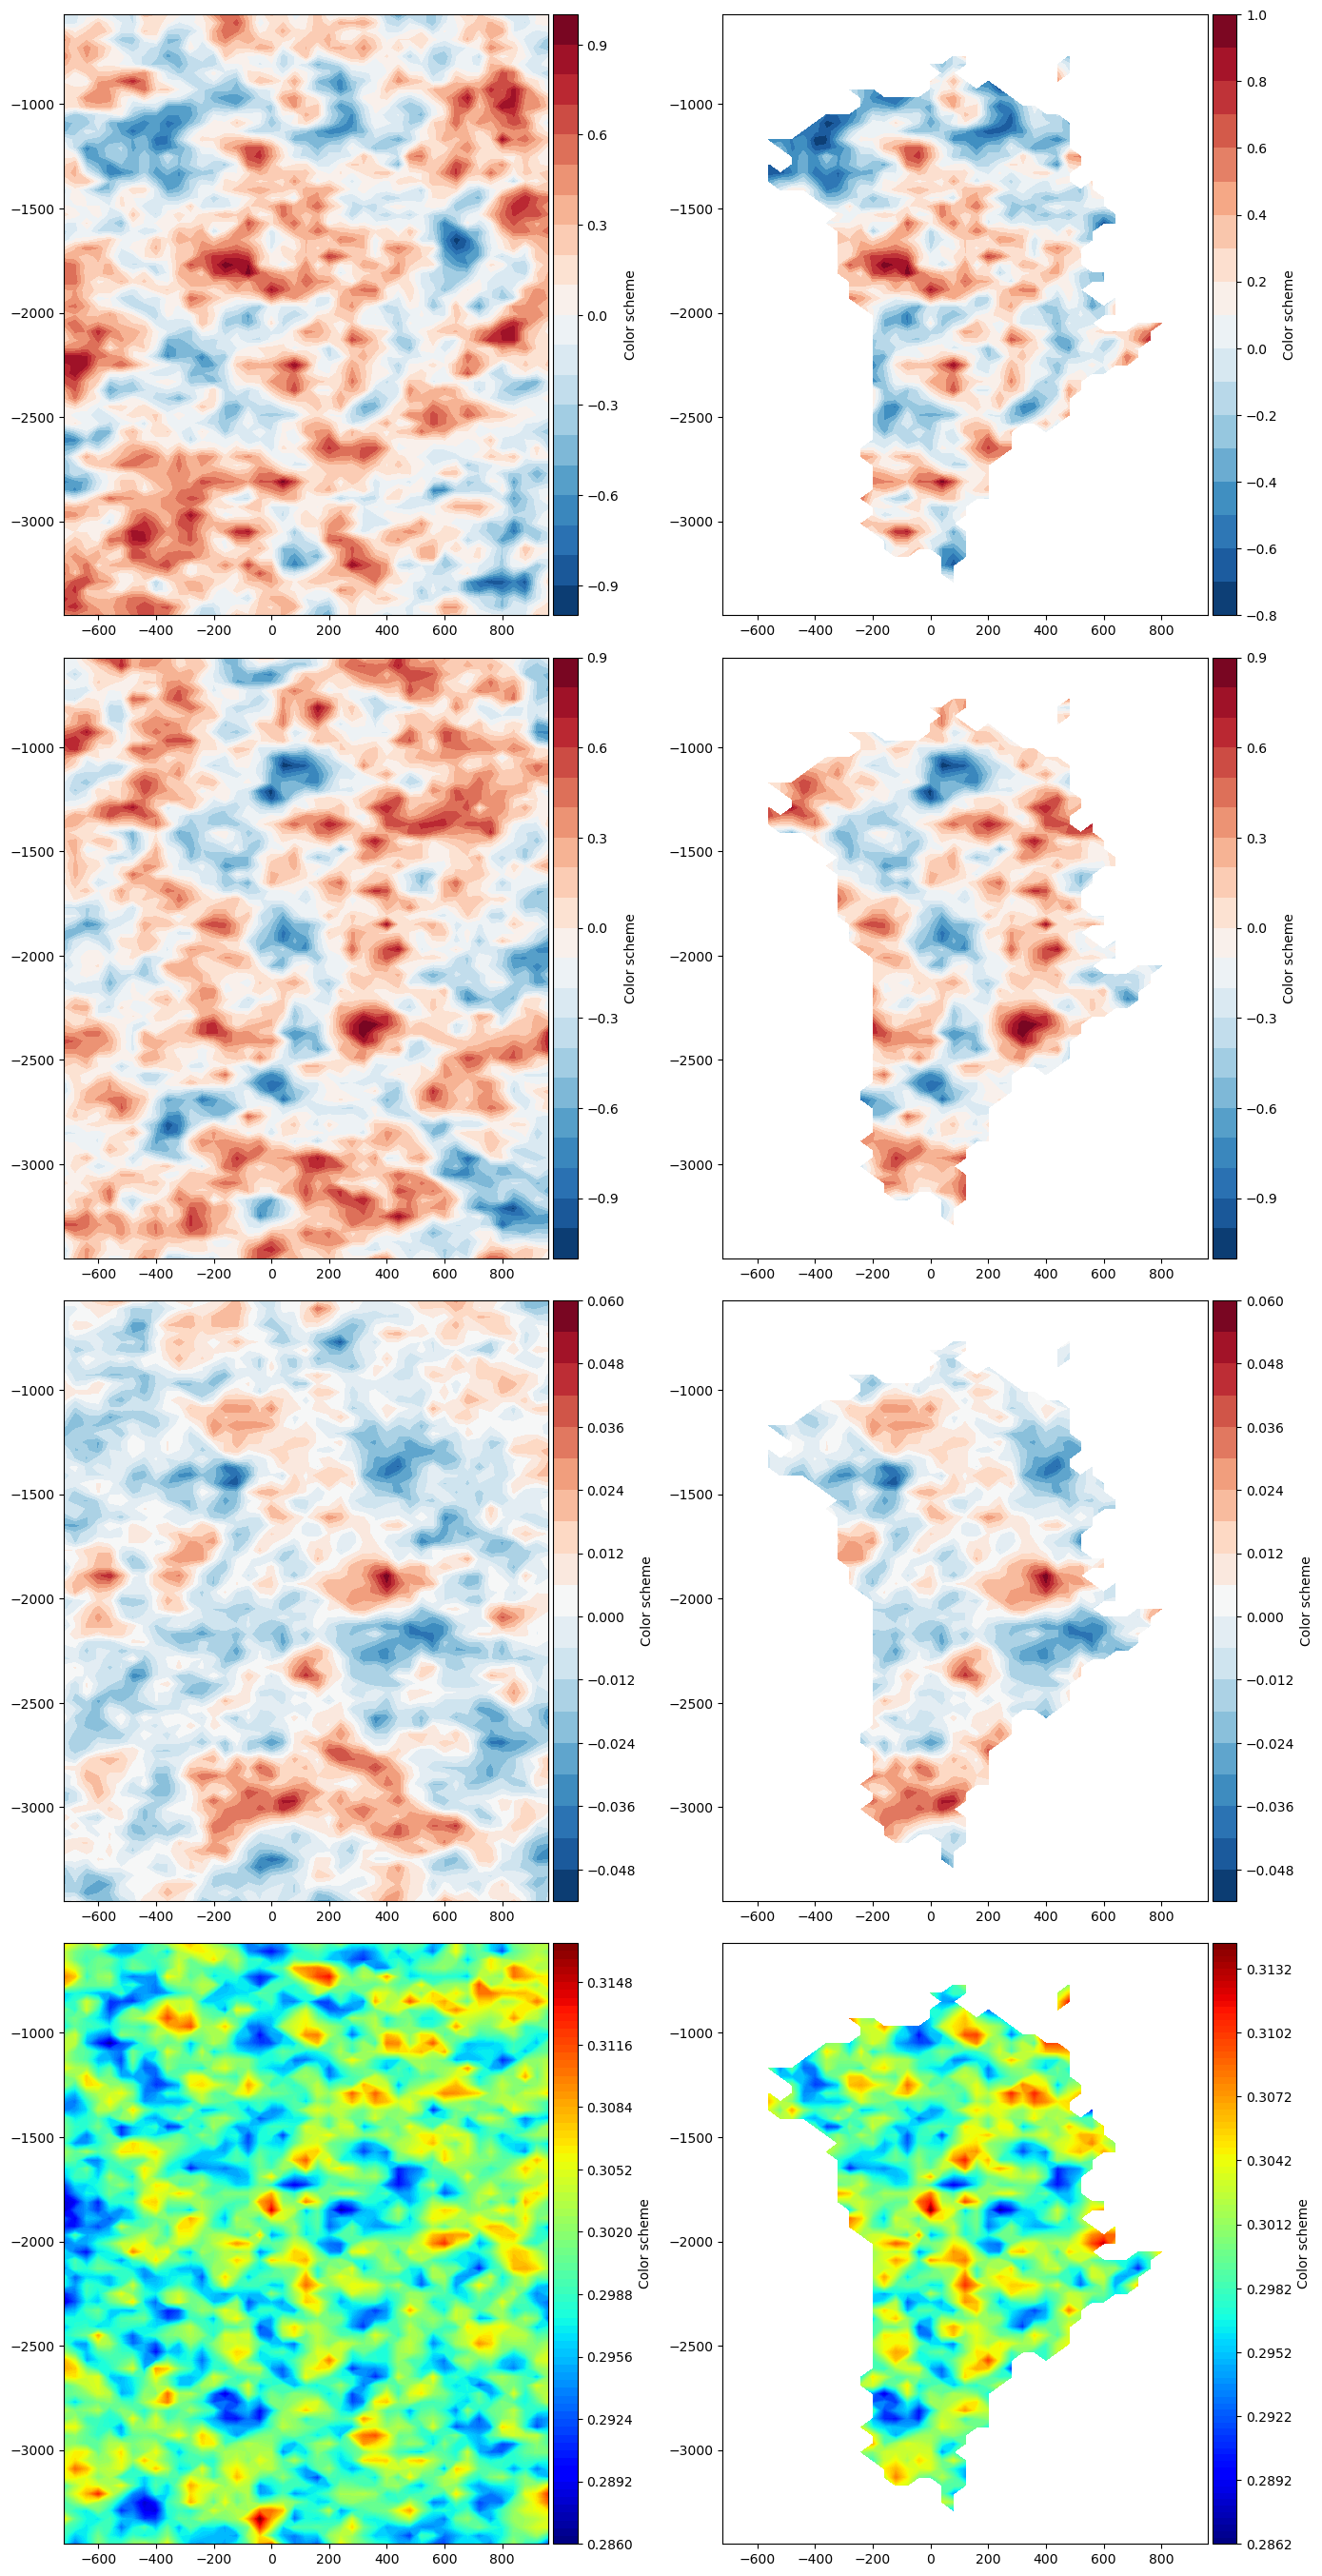

In [6]:
H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (16,24)
n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [7]:
np.min(ds_std_samples_prior["xx_c_slide_initd"].data), \
np.max(ds_std_samples_prior["xx_c_slide_initd"].data)

(0.28606454184296487, 0.31645614716404113)

In [8]:
ds_x = DA.create_ad_tlm_action_input_nc(bool_randomize = True)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(65202449.90837421, 65202449.90837376)

In [9]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(65202449.90837421, 65202449.90837376)

In [10]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")
ds_A_SigmaXCx = DA.eval_tlm_action()
ds_noise_cov_inv_A_SigmaXCx = DA.eval_noise_cov_inv_action(ds_A_SigmaXCx)

dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)

ds_CT_XT_SigmaT_H_misfit_SigmaXCx = DA.eval_prior_preconditioned_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]), DA.l2_inner_product([ds_A_SigmaXCx, ds_noise_cov_inv_A_SigmaXCx], ["tlmhessaction", "adjhessaction"])

(412615.4336590178, 412615.433659017)

In [11]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")
ds_SigmaXC_inv_SigmaXCx = DA.eval_sqrt_prior_cov_inv_action()

DA.l2_inner_product([ds_SigmaXC_inv_SigmaXCx, ds_SigmaXC_inv_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"])

(6109.301815965427, 6109.3018159654275)

In [12]:
DA.l2_inner_product([ds_SigmaXCx, ds_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"])

(563.5832470520472, 6109.3018159654275)

In [13]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()

ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")

ds_SigmaXCx_as_adj_fields = xr.open_dataset(DA.dict_ad_inp_nc_files["tlm_action"])
ds_SigmaXCx_as_adj_fields = ds_SigmaXCx_as_adj_fields.rename({field + "d": field + "b" for field in dict_og_params_fields_vals})
for var in ds_SigmaXCx_as_adj_fields:
    if ds_SigmaXCx_as_adj_fields[var].attrs["type"] == "tlm":
        ds_SigmaXCx_as_adj_fields[var].attrs["type"] = "adj"
        if dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "2D":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1))
        elif dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "3D":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1)*(KCMAX+1))
        elif dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "3DR":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1)*(KRMAX+1))
ds_SigmaXCx_as_adj_fields.to_netcdf(DA.dict_ad_out_nc_files["adj_action"])

ds_CT_XT_SigmaT_SigmaXCx = DA.eval_sqrt_prior_covT_action(ad_key_adj_or_adj_action = "adj_action")

DA.l2_inner_product([ds_SigmaXCx, ds_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_SigmaXCx], ["tlm", "adj"])

(563.5832470520472, 563.5832470520472)

In [14]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_CT_XT_SigmaT_H_SigmaXCx = DA.eval_prior_preconditioned_hessian_action()

DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]), \
DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]) + DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"]), \
DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_SigmaXCx], ["tlm", "adj"])

(412615.4336590178, 418724.73547498323, 418724.7354749831)

In [15]:
# DA = optim.DataAssimilation(sicopolis_dir, simulation,
#                             dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
#                             dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
#                             dict_og_params_fields_vals, dict_prior_params_fields_vals, dict_params_fields_num_dims, 
#                             dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
#                             dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
#                             MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini_exact_gamma_delta", None, ds_prior_X)

# ds = DA.gradient_descent(2, init_alpha = 1.0, min_alpha_tol = 1.e-10)

# H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
# H_data = H_data_40["H"].data
# mask = 1.0*(H_data > 0)
# mask[mask == 0] = np.nan

# n_rows, n_cols = 2, 2
# aspect_ratio = len(xModel40)/len(yModel40)
# subplot_width = 4
# subplot_height = subplot_width / aspect_ratio
# plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
# fig, ax = plt.subplots(n_rows, n_cols)

# fancyPlotter.plot_normal(xModel40, 
#                          yModel40, 
#                          ds["xx_c_slide_init"].data,
#                          cmap = 'RdBu_r', nbins = 20, vmin = -1, vmax = 1, fig = fig, ax = ax[0, 0])
# fancyPlotter.plot_normal(xModel40, 
#                          yModel40, 
#                          ds["xx_c_slide_init"].data*mask,
#                          cmap = 'RdBu_r', nbins = 20, vmin = -1, vmax = 1, fig = fig, ax = ax[0, 1])
# fancyPlotter.plot_normal(xModel40, 
#                          yModel40, 
#                          10**ds["xx_c_slide_init"].data,
#                          cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 0])
# fancyPlotter.plot_normal(xModel40, 
#                          yModel40, 
#                          10**ds["xx_c_slide_init"].data*mask,
#                          cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 1])
# plt.tight_layout()

---------------------------------------------------------------------------------------------------------------
Initial fc = 650822.595775314, fc_data = 650822.595775314, fc_reg = 0.0
---------------------------------------------------------------------------------------------------------------
CG iter 1
eps_TOL_CG: 175559.50531002923, norm_r_hat: 76974.27556319836
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  180.0
Step size alpha = 1.0
---------------------------------------------------------------------------------------------------------------
Outer iter 1, fc = 158567.96280509917, fc_data = 158563.0040626814, fc_reg = 4.958742417763205
---------------------------------------------------------------------------------------------------------------
CG iter 1
eps_TOL_CG: 32799.82743765424, norm_r_hat: 12768.054054301485
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  180.0
Step size alpha = 1.0
---------------------------------

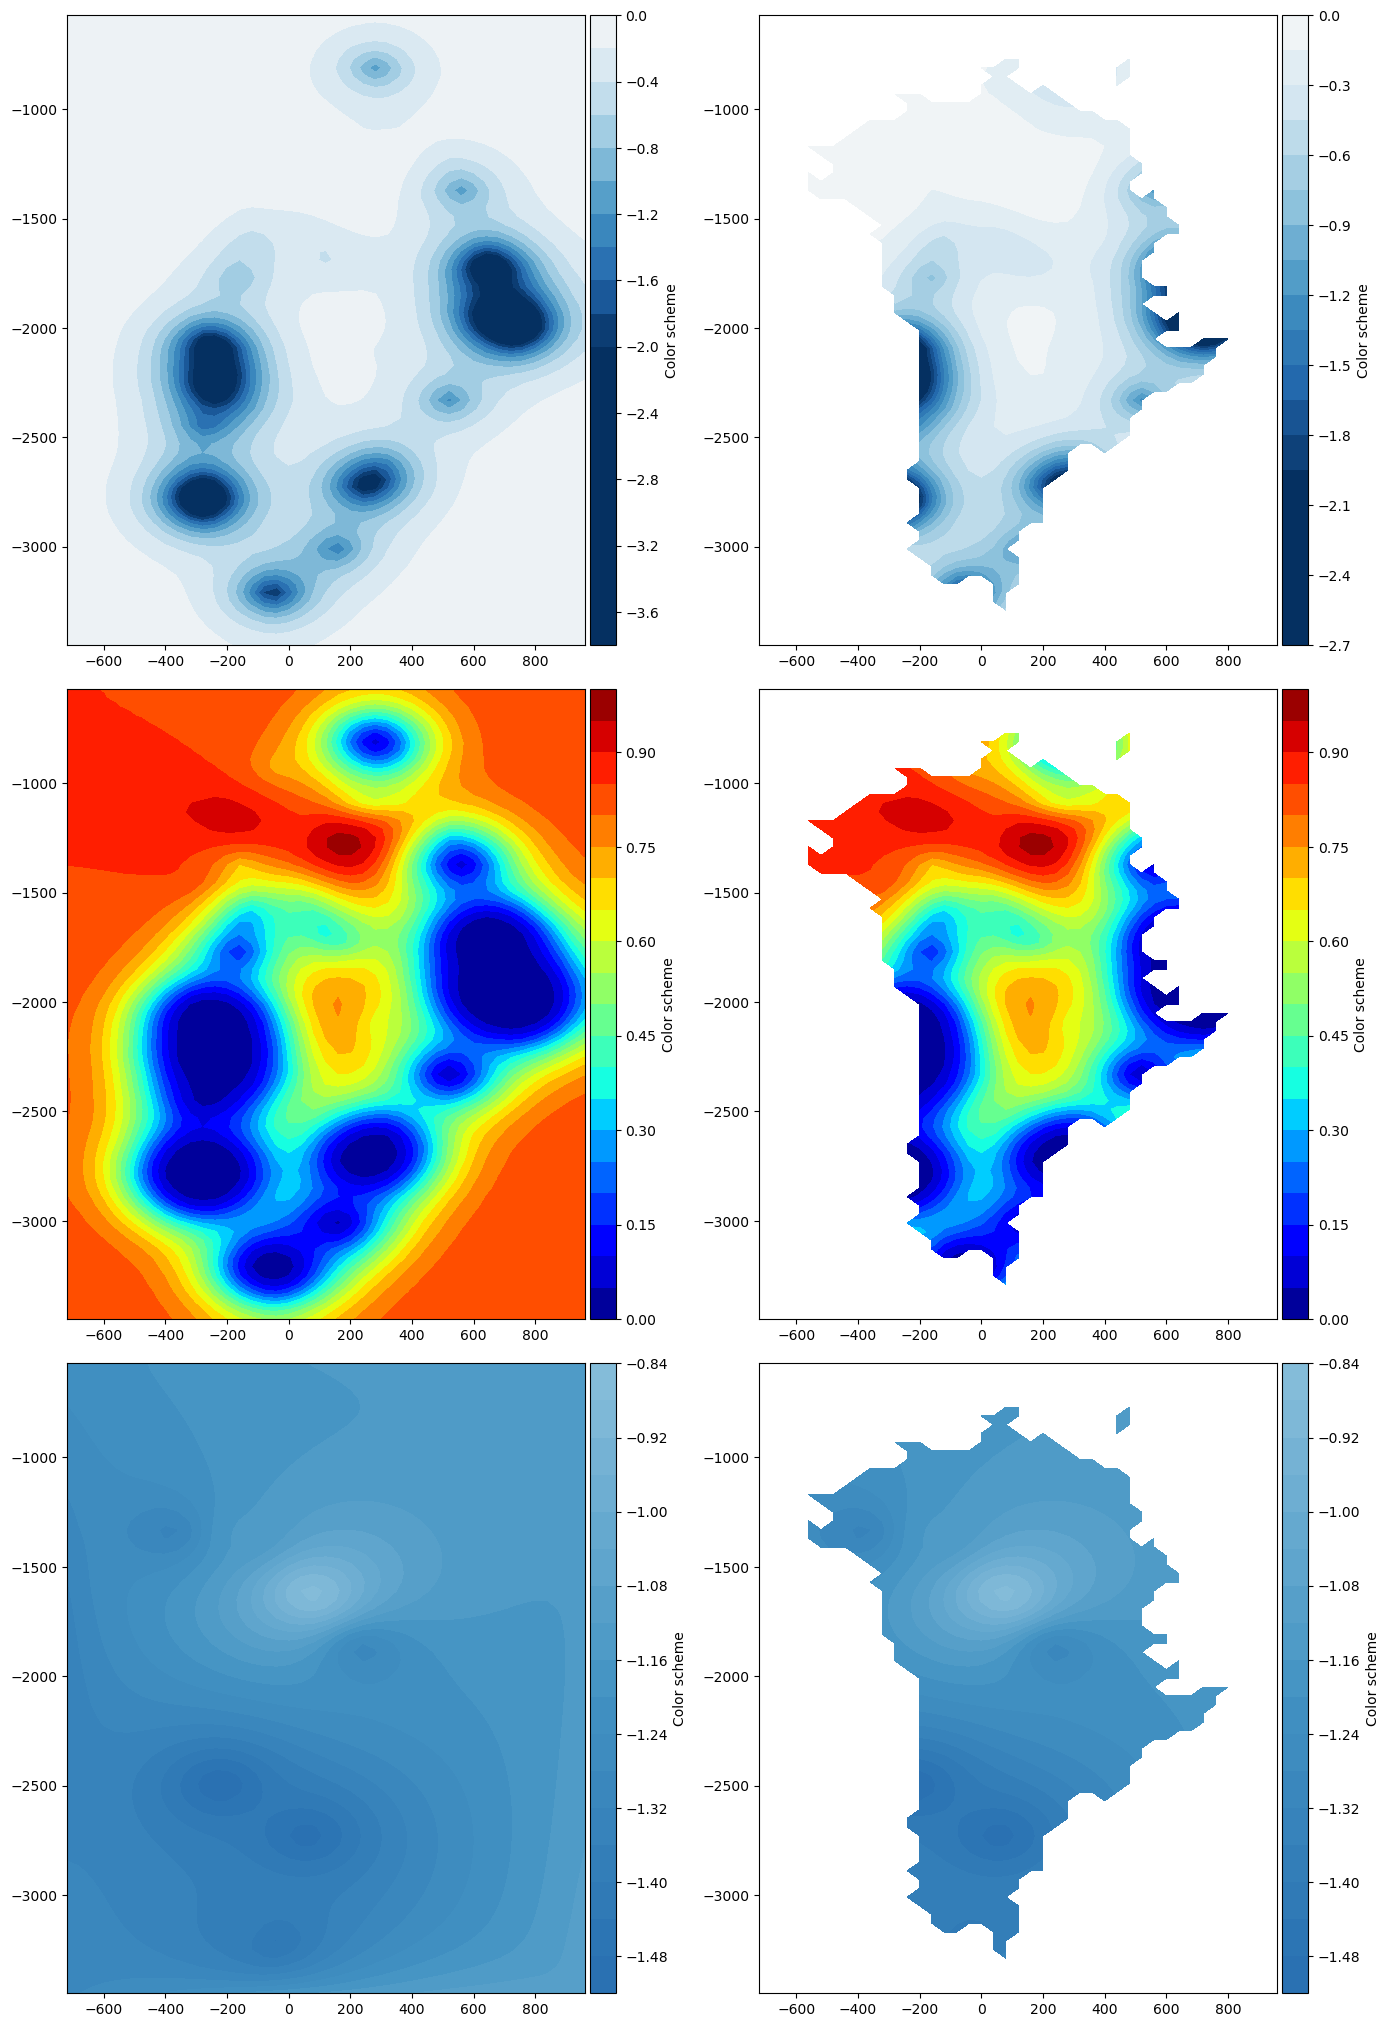

In [16]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_prior_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini_exact_gamma_delta", None, ds_prior_X, "0002.nc")

ds = DA.inexact_gn_hessian_cg(MAX_ITERS = 5, min_alpha_cg_tol = 1.e-20, init_alpha_gd = 1.e-6, min_alpha_gd_tol = 1.e-20)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 3, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data,
                         cmap = 'RdBu_r', nbins = 20, vmin = -2, vmax = 2, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -2, vmax = 2, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data*mask,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_q_geo"].data,
                         cmap = 'RdBu_r', nbins = 20, vmin = -2, vmax = 2, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_q_geo"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -2, vmax = 2, fig = fig, ax = ax[2, 1])
plt.tight_layout()

In [17]:
temp = xr.open_dataset("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/inexact_gn_hessian_cg/final_sim_output_GNHessCG_iter_1_fields.nc")
0.5*np.sum((temp["vx_s_g"].data - surfvel_data_40kms["vx"].data)**2/surfvel_data_40kms["vx_uncert"].data**2 + (temp["vy_s_g"].data - surfvel_data_40kms["vy"].data)**2/surfvel_data_40kms["vy_uncert"].data**2)

158563.00471464236

In [18]:
ds

<xarray.Dataset> Size: 51kB
Dimensions:                        (y: 73, x: 43, scalar: 1)
Coordinates:
  * y                              (y) float64 584B -3.45e+03 ... -570.0
  * x                              (x) float64 344B -720.0 -680.0 ... 960.0
Dimensions without coordinates: scalar
Data variables:
    xx_c_slide_init                (y, x) float64 25kB -0.07149 ... -0.07089
    xx_q_geo                       (y, x) float64 25kB -1.286 -1.28 ... -1.146
    xx_p_weert                     (scalar) float64 8B 0.5145
    xx_q_weert                     (scalar) float64 8B 0.2623
    xx_enh_fact_da_dummy2d_scalar  (scalar) float64 8B -0.004718
    xx_enh_intg_da_dummy2d_scalar  (scalar) float64 8B -0.05436
    xx_n_glen_da_dummy2d_scalar    (scalar) float64 8B 0.7568

In [19]:
temp = xr.open_dataset("/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneCS_mini_exact_gamma_delta/src/subroutines/tapenade/ad_io/ad_output_adj.nc")
temp["xx_n_glen_da_dummy2d_scalar"].data[0], ds["xx_n_glen_da_dummy2d_scalar"].data[0]

(0.6005712175703922, 0.756807144265407)

In [20]:
# start_dp = time.time()

# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise")
# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise", 
#                                                                                                               Omega = Omega_misfit_dp, Y = Y_misfit_dp, Q = Q_misfit_dp, MQ = MQ_misfit_dp)

# end_dp = time.time()
# print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
# start_sa = time.time()

# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx")
# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx", 
#                                                                                                               Omega = Omega_misfit_sa, Y = Y_misfit_sa, Q = Q_misfit_sa, MQ = MQ_misfit_sa)

# end_sa = time.time()
# print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

# plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
# plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

# plt.axhline(1, color = "green")

# np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

In [21]:
# start_dp = time.time()

# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise")
# Omega_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/REVD_double_precise/Omega_misfit.npy")
# Y_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/REVD_double_precise/Y_misfit.npy")
# Q_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/REVD_double_precise/Q_misfit.npy")
# MQ_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/REVD_double_precise/MQ_misfit.npy")
# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise", 
#                                                                                                               Omega = Omega_misfit_dp, Y = Y_misfit_dp, Q = Q_misfit_dp, MQ = MQ_misfit_dp)

# end_dp = time.time()
# print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
# start_sa = time.time()

# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx")
# Omega_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/REVD_single_approx/Omega_misfit.npy")
# Y_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/REVD_single_approx/Y_misfit.npy")
# Q_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/REVD_single_approx/Q_misfit.npy")
# MQ_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/REVD_single_approx/MQ_misfit.npy")
# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx", 
#                                                                                                               Omega = Omega_misfit_sa, Y = Y_misfit_sa, Q = Q_misfit_sa, MQ = MQ_misfit_sa)

# end_sa = time.time()
# print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

# plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
# plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

# plt.axhline(1, color = "green")

# np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

Relative symmetry error of T:  3.615173746844919e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  2.0604306462787933e-15
eig (symmetrized) vs eigh:  1.7977609299858617e-15
First 10 eigenvalues: [2.4400922  1.75028395 1.68226776 1.27077051 1.11617031 1.0447822
 0.94812819 0.79483174 0.63601062 0.60259682]
Relative symmetry error of T:  4.0737904039994425e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.167863150713056e-15
eig (symmetrized) vs eigh:  1.0947694380889939e-15
First 13 eigenvalues: [2.49235505 1.85495209 1.73318545 1.35317479 1.13231139 1.07763294
 0.96529234 0.85515118 0.79853438 0.68839645 0.60939741 0.52105993
 0.46594195]
Double precise total time: 200.4547 seconds


/home/shreyas/pySICOPOLIS/src/pySICOPOLIS/optim/optim.py:1667: RuntimeWarning: revd: Check the comments at the start of this function to see what might be missing from the single pass, it's essentially remark 5.4 of Halko, Martinsson, Tropp's paper.
  Omega = np.hstack([Omega, omega.reshape(-1, 1)])


Condition number of Q.T @ Omega:  2.5188516687280598
Minimum singular value of Q.T @ Omega:  3.661138794764253
Condition number of Q.T @ Omega explicitly computed:  2.5188516687280575
Relative symmetry error of T:  1.66982916308788e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.2861908383759665e-15
eig (symmetrized) vs eigh:  2.0430294272154998e-15
First 10 eigenvalues: [2.17755467 1.51467907 1.38292691 0.96582854 0.84718539 0.78799654
 0.67905341 0.5549277  0.52257549 0.33070525]
Condition number of Q.T @ Omega:  2.807723679962413
Minimum singular value of Q.T @ Omega:  3.5869124643607293
Condition number of Q.T @ Omega explicitly computed:  2.807723679962413
Relative symmetry error of T:  1.8123059146475352e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.9424951237481002e-15
eig (symmet

(array([2.49235505, 1.85495209, 1.73318545, 1.35317479, 1.13231139,
        1.07763294, 0.96529234, 0.85515118, 0.79853438, 0.68839645,
        0.60939741, 0.52105993, 0.46594195]),
 array([2.22406522, 1.54463858, 1.43607843, 1.05548272, 0.9070114 ,
        0.85250039, 0.70048745, 0.63922469, 0.54460895, 0.40701823,
        0.29725784, 0.29293668, 0.26060727]))

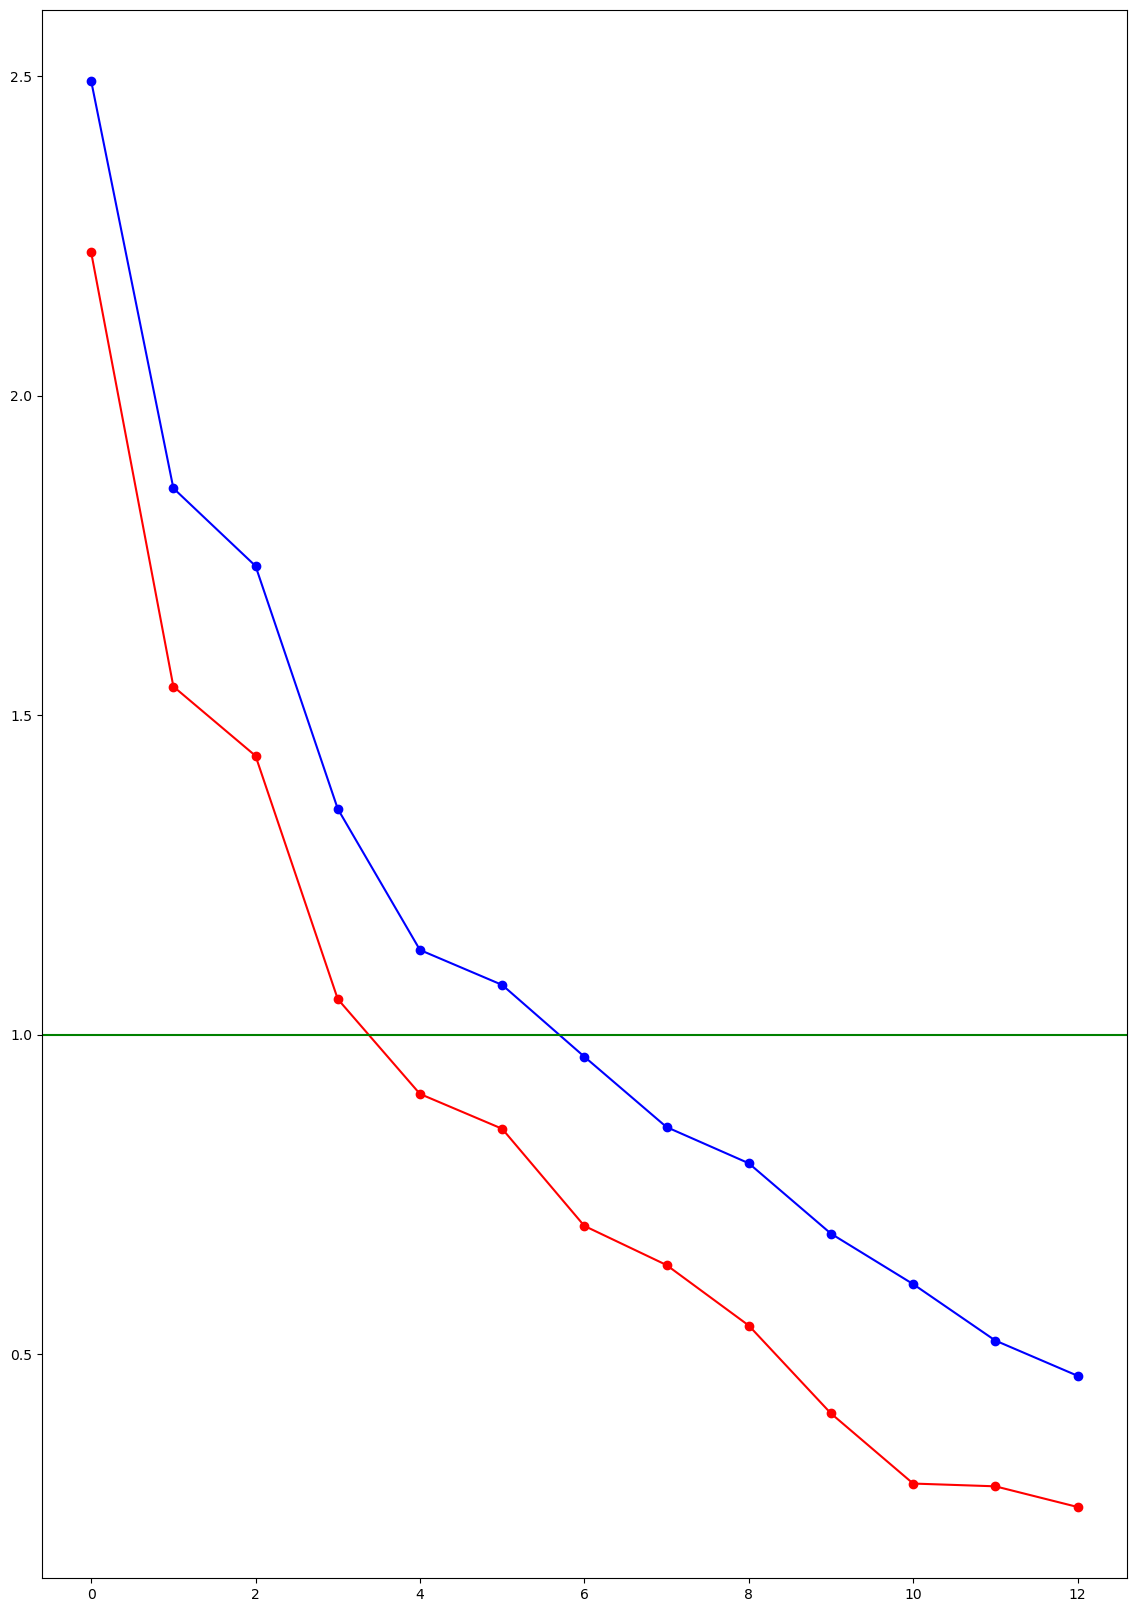

In [22]:
start_dp = time.time()
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(13, 5, mode = "misfit_prior_precond", str_pass = "double_precise")

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(13, 5, mode = "misfit_prior_precond", str_pass = "single_approx")

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

Relative symmetry error of T:  3.4318013816141083e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.334680187026084e-15
eig (symmetrized) vs eigh:  1.2113733761479957e-15
First 10 eigenvalues: [2.48435695 1.90878186 1.73539677 1.26337606 1.20114264 1.06591945
 0.9476656  0.83086345 0.72752452 0.66918897]
Relative symmetry error of T:  3.695686123534936e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.3529561668806721e-15
eig (symmetrized) vs eigh:  2.056244861306101e-15
First 20 eigenvalues: [2.52891673 1.99050389 1.79945375 1.45664318 1.22230888 1.11811424
 1.03092169 0.89089188 0.83950898 0.7943437  0.70129289 0.63836678
 0.53197089 0.47620698 0.35953746 0.34043635 0.3376424  0.29123794
 0.26486688 0.24915646]
Relative symmetry error of T:  3.677362643314936e-12
Complex parts check (imag > 

(array([2.54703306, 2.00537775, 1.81761056, 1.49774715, 1.23561114,
        1.14819847, 1.08340955, 0.9382918 , 0.87412465, 0.81881366,
        0.77711491, 0.70402579, 0.58019805, 0.53583277, 0.41565334,
        0.41020665, 0.38404529, 0.36681526, 0.33716461, 0.31115707,
        0.2876187 , 0.26044961, 0.24097371, 0.21397635, 0.18937415,
        0.18792682, 0.17225967, 0.15203594, 0.1455082 , 0.13953496,
        0.13307177, 0.1284494 , 0.12546376, 0.1250035 , 0.12125086,
        0.11444619, 0.10309016, 0.09916134, 0.09455656, 0.09057121,
        0.08256001, 0.07741241, 0.07474752, 0.07253391, 0.06971629,
        0.06441641, 0.05982339, 0.05644526, 0.04985588, 0.04724747]),
 array([2.44314953, 1.90172033, 1.73061746, 1.35339375, 1.15054786,
        1.06067873, 1.00946904, 0.84422362, 0.81601553, 0.72433966,
        0.64822427, 0.61570947, 0.48843353, 0.45277056, 0.37134652,
        0.33282218, 0.30119321, 0.29557905, 0.26718484, 0.24245401,
        0.21292071, 0.18873967, 0.17993808, 0.

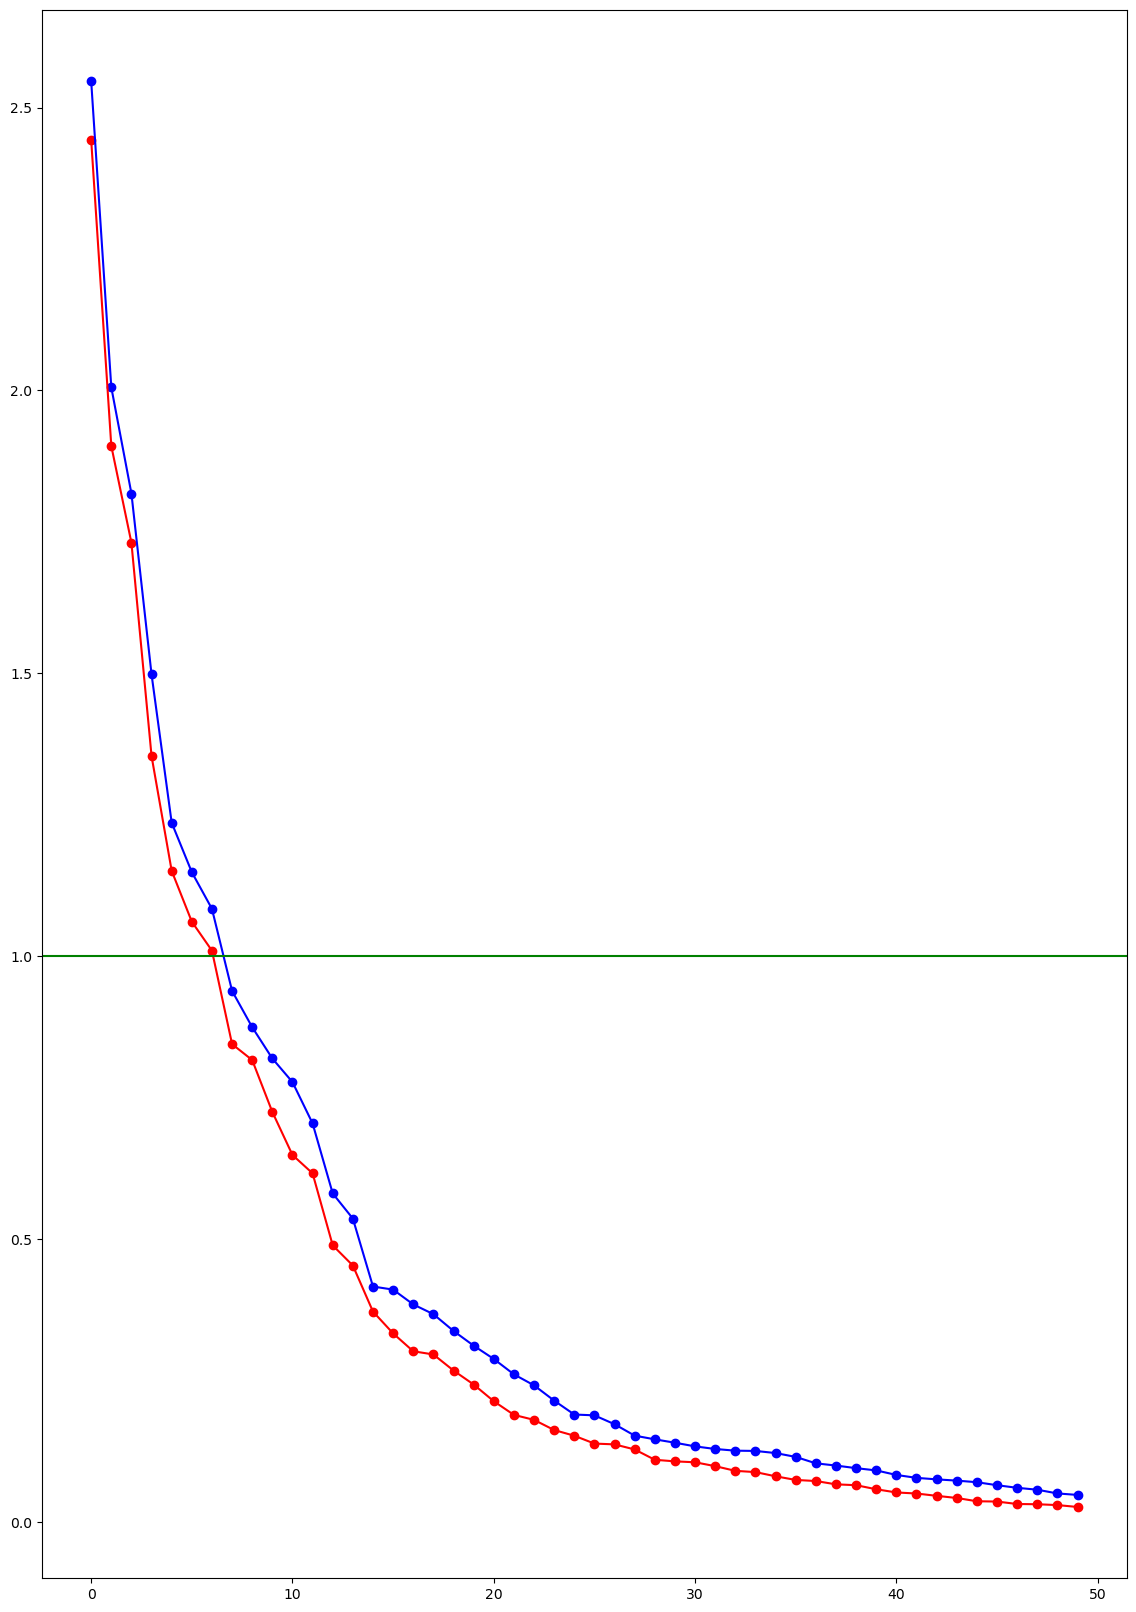

In [23]:
start_dp = time.time()
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(50, 5, mode = "misfit_prior_precond", str_pass = "double_precise")

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(50, 5, mode = "misfit_prior_precond", str_pass = "single_approx")

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

In [24]:
# ds_state = xr.open_dataset("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/inexact_gn_hessian_cg/state_GNHessCG_iter_5.nc")
# ds_prior_X = xr.open_dataset("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/prior_X.nc")

# dict_og_params_fields_vals = {"xx_c_slide_init": ds_state["xx_c_slide_init"].data.copy(),
#                               "xx_q_geo": ds_state["xx_q_geo"].data.copy(),
#                               "xx_p_weert": ds_state["xx_p_weert"].data[0].copy(),
#                               "xx_q_weert": ds_state["xx_q_weert"].data[0].copy(),
#                               "xx_enh_fact_da_dummy2d_scalar": ds_state["xx_enh_fact_da_dummy2d_scalar"].data[0].copy(),
#                               "xx_enh_intg_da_dummy2d_scalar": ds_state["xx_enh_intg_da_dummy2d_scalar"].data[0].copy(),
#                               "xx_n_glen_da_dummy2d_scalar": ds_state["xx_n_glen_da_dummy2d_scalar"].data[0].copy()}

# DA = optim.DataAssimilation(sicopolis_dir, simulation,
#                             dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
#                             dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
#                             dict_og_params_fields_vals, dict_prior_params_fields_vals, dict_params_fields_num_dims, 
#                             dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
#                             dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
#                             MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini_exact_gamma_delta", None, ds_prior_X)

# start_dp = time.time()

# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise")
# Omega_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/REVD_double_precise/Omega_misfit.npy")
# Y_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/REVD_double_precise/Y_misfit.npy")
# Q_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/REVD_double_precise/Q_misfit.npy")
# MQ_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/REVD_double_precise/MQ_misfit.npy")
# Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise", 
#                                                                                                               Omega = Omega_misfit_dp, Y = Y_misfit_dp, Q = Q_misfit_dp, MQ = MQ_misfit_dp)

# end_dp = time.time()
# print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
# start_sa = time.time()

# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx")
# Omega_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/REVD_single_approx/Omega_misfit.npy")
# Y_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/REVD_single_approx/Y_misfit.npy")
# Q_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/REVD_single_approx/Q_misfit.npy")
# MQ_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini_exact_gamma_delta/REVD_single_approx/MQ_misfit.npy")
# Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(20, 5, mode = "misfit_prior_precond", str_pass = "single_approx", 
#                                                                                                               Omega = Omega_misfit_sa, Y = Y_misfit_sa, Q = Q_misfit_sa, MQ = MQ_misfit_sa)

# end_sa = time.time()
# print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

# plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
# plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
# plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

# plt.axhline(1, color = "green")

# np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

Relative symmetry error of T:  3.2228015922604503e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  1.7253123210581329e-15
eig (symmetrized) vs eigh:  1.4676659756498198e-15
First 10 eigenvalues: [2.4904034  1.9670433  1.78789171 1.34735802 1.19172795 1.07241191
 1.02907364 0.83941534 0.82873505 0.69840556]
Relative symmetry error of T:  3.809752708843011e-12
Complex parts check (imag > 2.2e-16): 
eig (unsymm):  False
eig (symm):    False
eigh:          False
Relative error: 
eig (unsymm) vs eigh:  2.3056624901947284e-15
eig (symmetrized) vs eigh:  1.9174502539876895e-15
First 20 eigenvalues: [2.51563445 1.98960887 1.80733175 1.48110841 1.21568608 1.12279897
 1.04897027 0.91296531 0.85749414 0.75863425 0.73335347 0.64786201
 0.55236227 0.48924684 0.39823266 0.37458857 0.35517146 0.32058791
 0.28187371 0.2624451 ]
Relative symmetry error of T:  3.88946240007859e-12
Complex parts check (imag >

(array([2.54887285e+00, 2.00701086e+00, 1.81876356e+00, 1.50373080e+00,
        1.23792182e+00, 1.15136843e+00, 1.08874935e+00, 9.41894004e-01,
        8.80228501e-01, 8.22075166e-01, 7.86110873e-01, 7.08522407e-01,
        5.84603286e-01, 5.40840434e-01, 4.29308148e-01, 4.22226777e-01,
        3.94024909e-01, 3.74451389e-01, 3.47606836e-01, 3.20040837e-01,
        2.99919102e-01, 2.76370508e-01, 2.50620181e-01, 2.22730293e-01,
        2.09207666e-01, 1.97765953e-01, 1.87582461e-01, 1.73723756e-01,
        1.60149778e-01, 1.57935947e-01, 1.49399778e-01, 1.44172967e-01,
        1.41220025e-01, 1.39507117e-01, 1.37432097e-01, 1.32033688e-01,
        1.31745145e-01, 1.16692262e-01, 1.14527533e-01, 1.11763279e-01,
        1.06819967e-01, 9.77302050e-02, 9.45578241e-02, 8.99893009e-02,
        8.83255922e-02, 8.70414683e-02, 8.49186213e-02, 8.41014623e-02,
        8.06906455e-02, 7.39195050e-02, 6.80894219e-02, 6.64142419e-02,
        6.58817101e-02, 5.95000535e-02, 5.73546885e-02, 5.527849

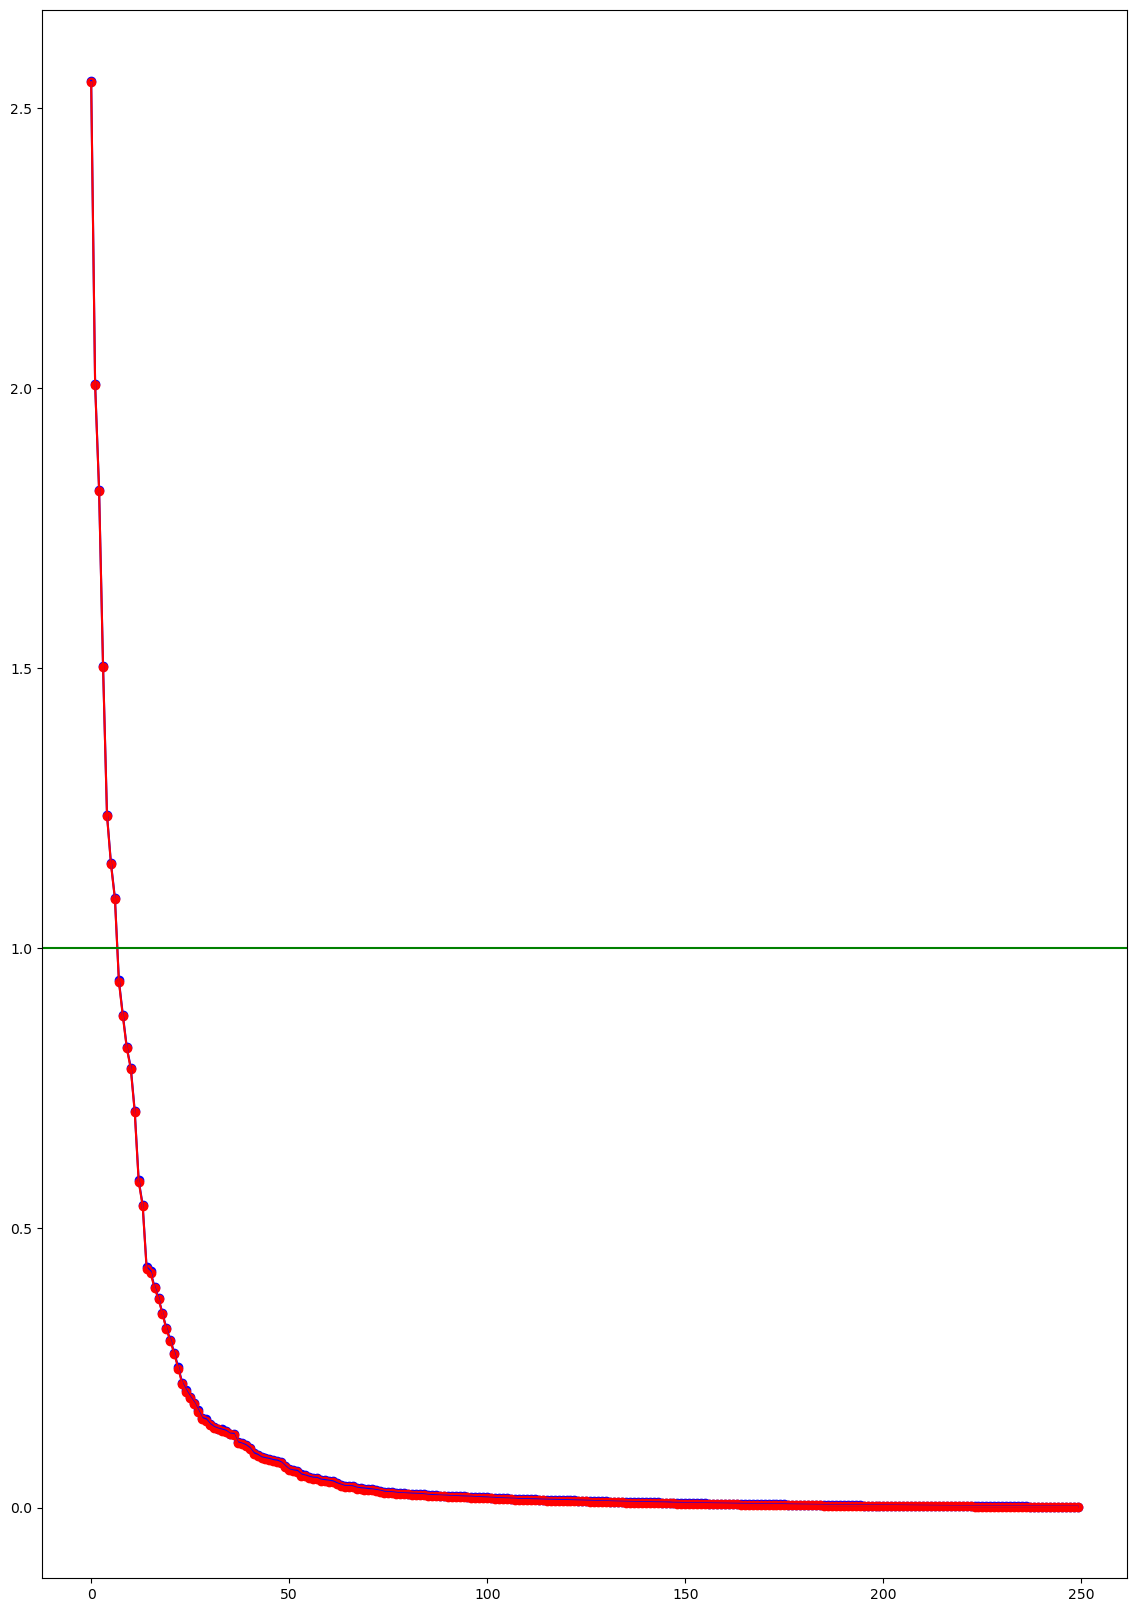

In [25]:
start_dp = time.time()
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(250, 10, mode = "misfit_prior_precond", str_pass = "double_precise")

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(250, 10, mode = "misfit_prior_precond", str_pass = "single_approx")

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

In [26]:
# sigma_B_squared_dp, sigma_P_squared_dp, delta_sigma_qoi_squared_dp = DA.forward_uq_propagation(U_misfit_dp, Lambda_misfit_dp)
sigma_B_squared_sa, sigma_P_squared_sa, delta_sigma_qoi_squared_sa = DA.forward_uq_propagation(U_misfit_sa, Lambda_misfit_sa)

# sigma_B_squared_dp, sigma_P_squared_dp, delta_sigma_qoi_squared_dp, sigma_B_squared_sa, sigma_P_squared_sa, delta_sigma_qoi_squared_sa
sigma_B_squared_sa, sigma_P_squared_sa, delta_sigma_qoi_squared_sa

(2.159459153160412e+17, 1.1406910313027234e+17, 0.471770035736356)

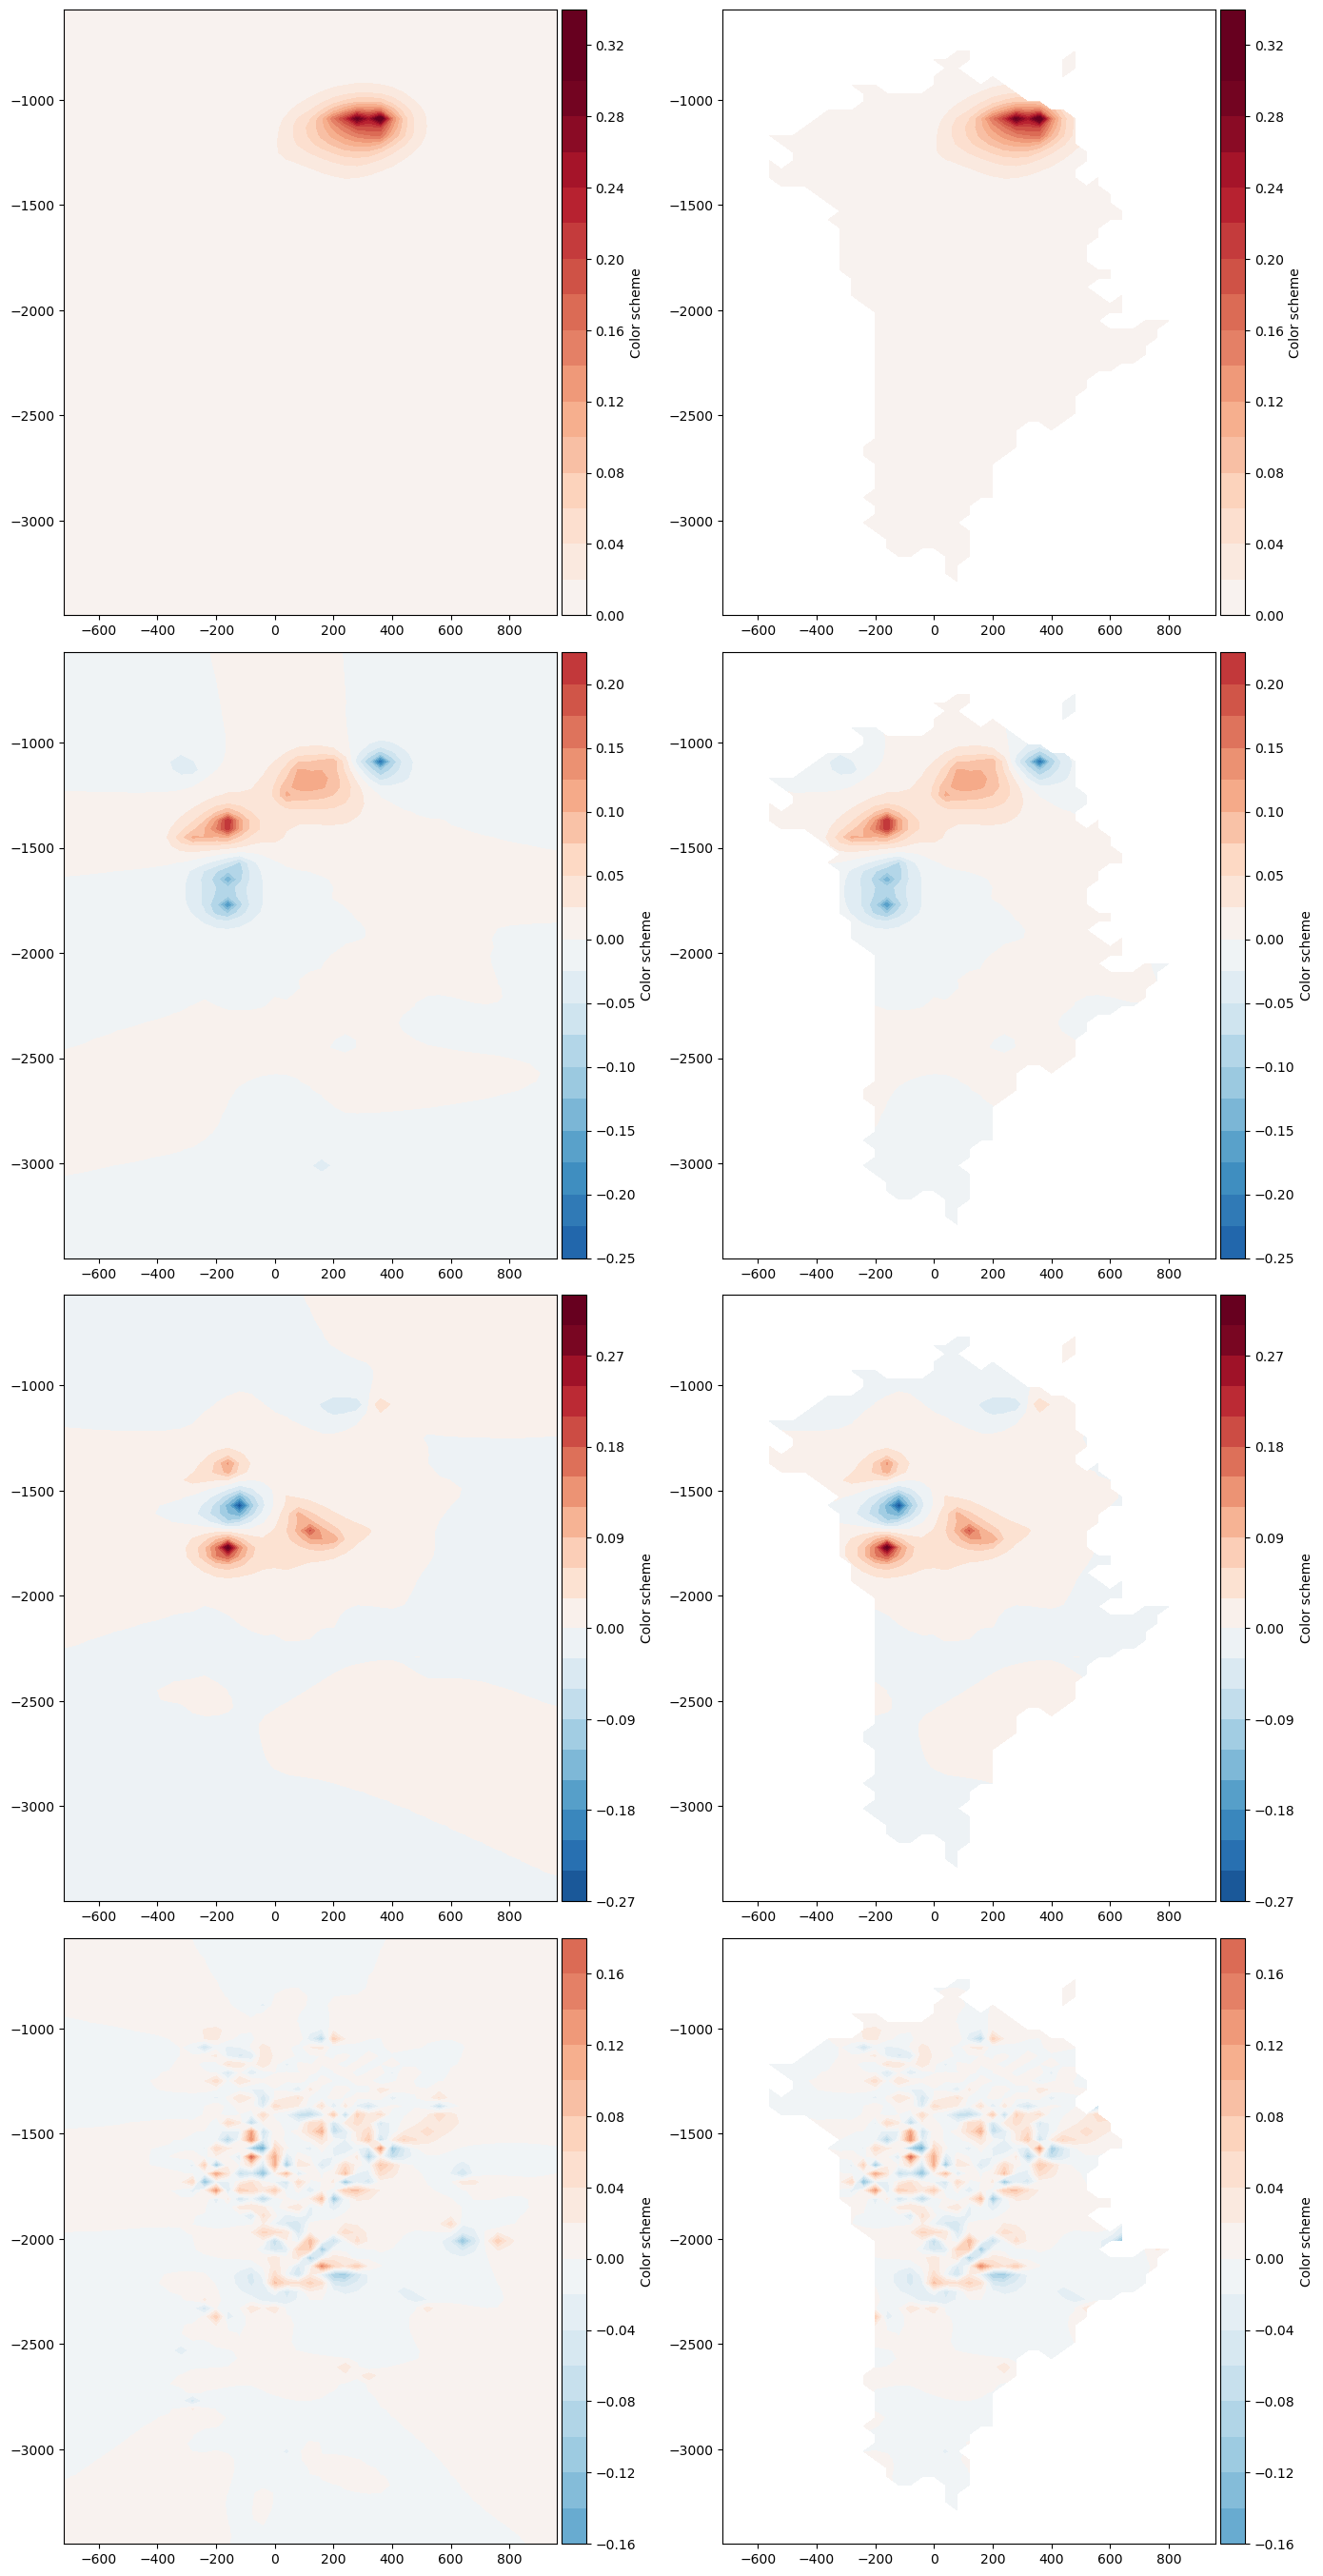

In [27]:
U_misfit_dp_reshaped = np.reshape(U_misfit_dp[:73*43, :], (73, 43, -1))

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 0],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 0]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 5],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 5]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 10],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 10]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, -1],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, -1]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 1])
plt.tight_layout()

Pearson correlation y-direction 40 kms:  0.752972623525091
Pearson correlation y-direction 80 kms:  0.4913987024448407
Pearson correlation y-direction 120 kms:  0.28955676272551817
Pearson correlation y-direction 160 kms:  0.15322991744637002
Pearson correlation y-direction 200 kms:  0.05214631414726464
Pearson correlation y-direction 240 kms:  0.013529400838089026
Pearson correlation y-direction 280 kms:  -0.0035347580950194166
Pearson correlation y-direction 320 kms:  -0.010339281888737175
Pearson correlation y-direction 360 kms:  -0.03345334552297863
Pearson correlation y-direction 400 kms:  -0.029826371999910752
Pearson correlation x-direction 40 kms:  0.75328680342615
Pearson correlation x-direction 80 kms:  0.49679574864681425
Pearson correlation x-direction 120 kms:  0.2949936368619492
Pearson correlation x-direction 160 kms:  0.1809601055660998
Pearson correlation x-direction 200 kms:  0.12458099978896321
Pearson correlation x-direction 240 kms:  0.0556288023504689
Pearson corr

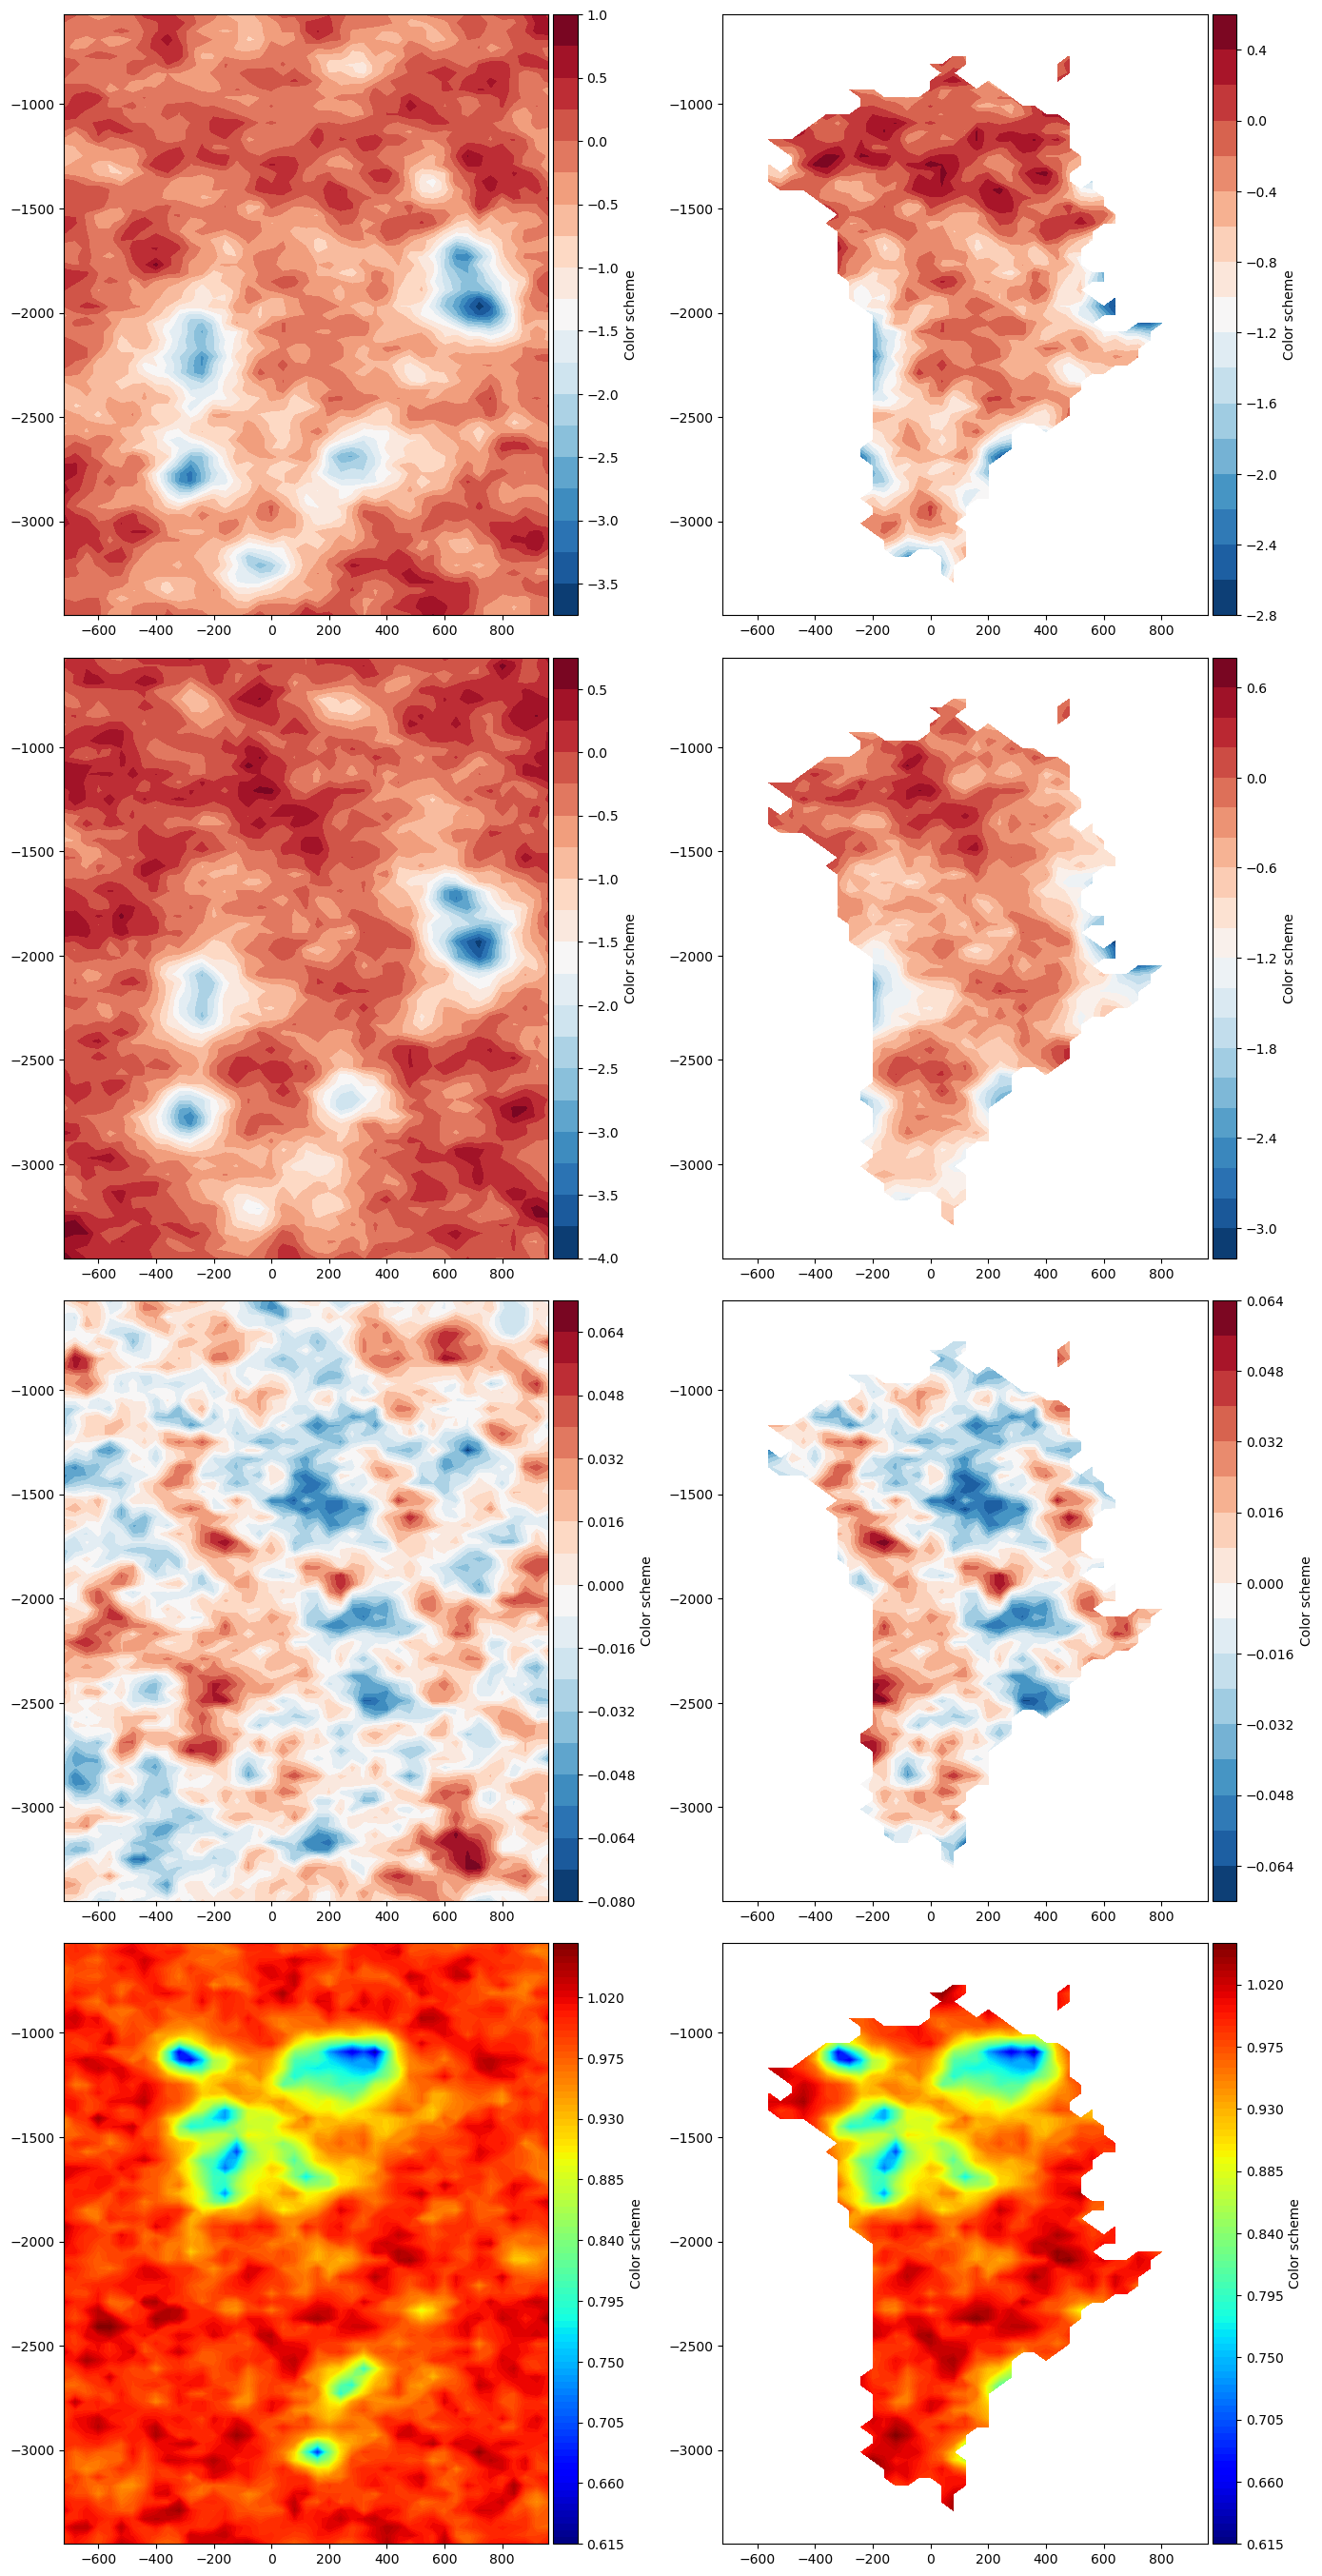

In [28]:
ds_subset_sample_posterior_1 = DA.sample_posterior(U_misfit_dp, Lambda_misfit_dp)
ds_subset_sample_posterior_2 = DA.sample_posterior(U_misfit_dp, Lambda_misfit_dp)
ds_mean_samples_posterior, ds_std_samples_posterior = DA.pointwise_marginals("posterior", 2000, U_misfit_dp, Lambda_misfit_dp)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

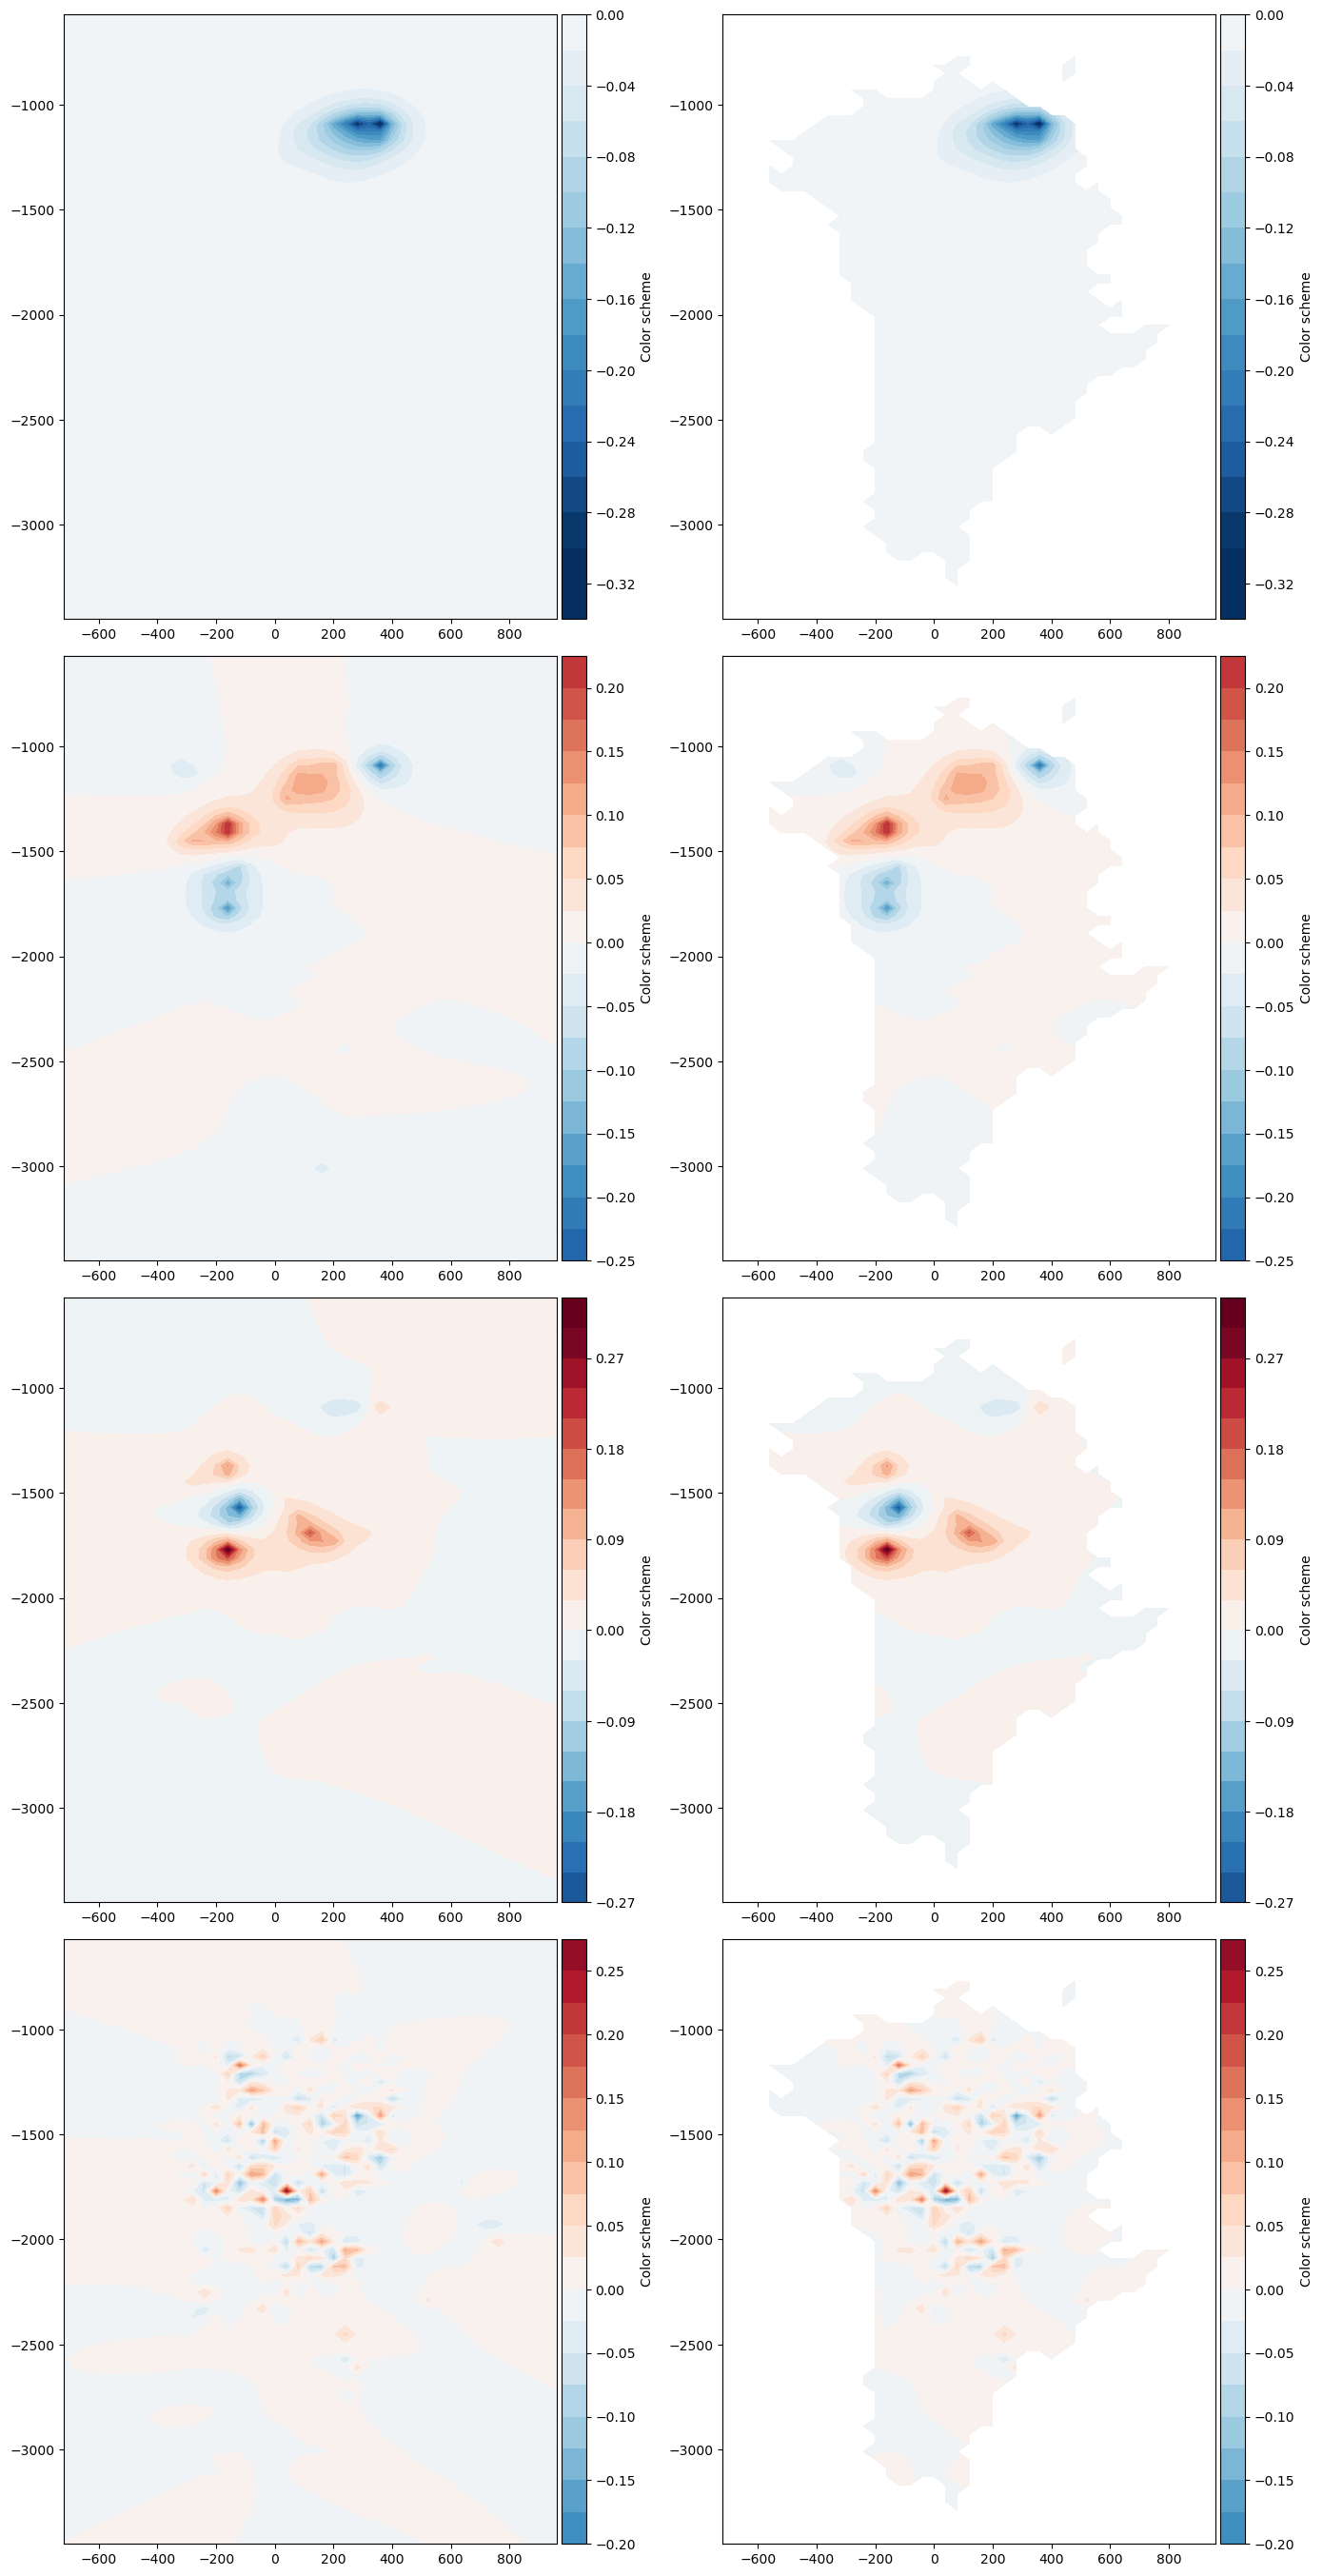

In [29]:
U_misfit_sa_reshaped = np.reshape(U_misfit_sa[:73*43, :], (73, 43, -1))

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 0],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 0]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 5],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 5]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 10],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 10]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, -1],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, -1]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 1])
plt.tight_layout()

Pearson correlation y-direction 40 kms:  0.7210207520816061
Pearson correlation y-direction 80 kms:  0.4646849677047707
Pearson correlation y-direction 120 kms:  0.32273220498574634
Pearson correlation y-direction 160 kms:  0.16789570867526266
Pearson correlation y-direction 200 kms:  0.06955361547052212
Pearson correlation y-direction 240 kms:  0.014564078314497901
Pearson correlation y-direction 280 kms:  0.006004716432602848
Pearson correlation y-direction 320 kms:  -0.03033733208215529
Pearson correlation y-direction 360 kms:  -0.00638485253892628
Pearson correlation y-direction 400 kms:  0.01571136426601711
Pearson correlation x-direction 40 kms:  0.7332043896780313
Pearson correlation x-direction 80 kms:  0.4531436619015417
Pearson correlation x-direction 120 kms:  0.30783096687623557
Pearson correlation x-direction 160 kms:  0.21430695548742457
Pearson correlation x-direction 200 kms:  0.11333316028585706
Pearson correlation x-direction 240 kms:  0.05107421956523316
Pearson corr

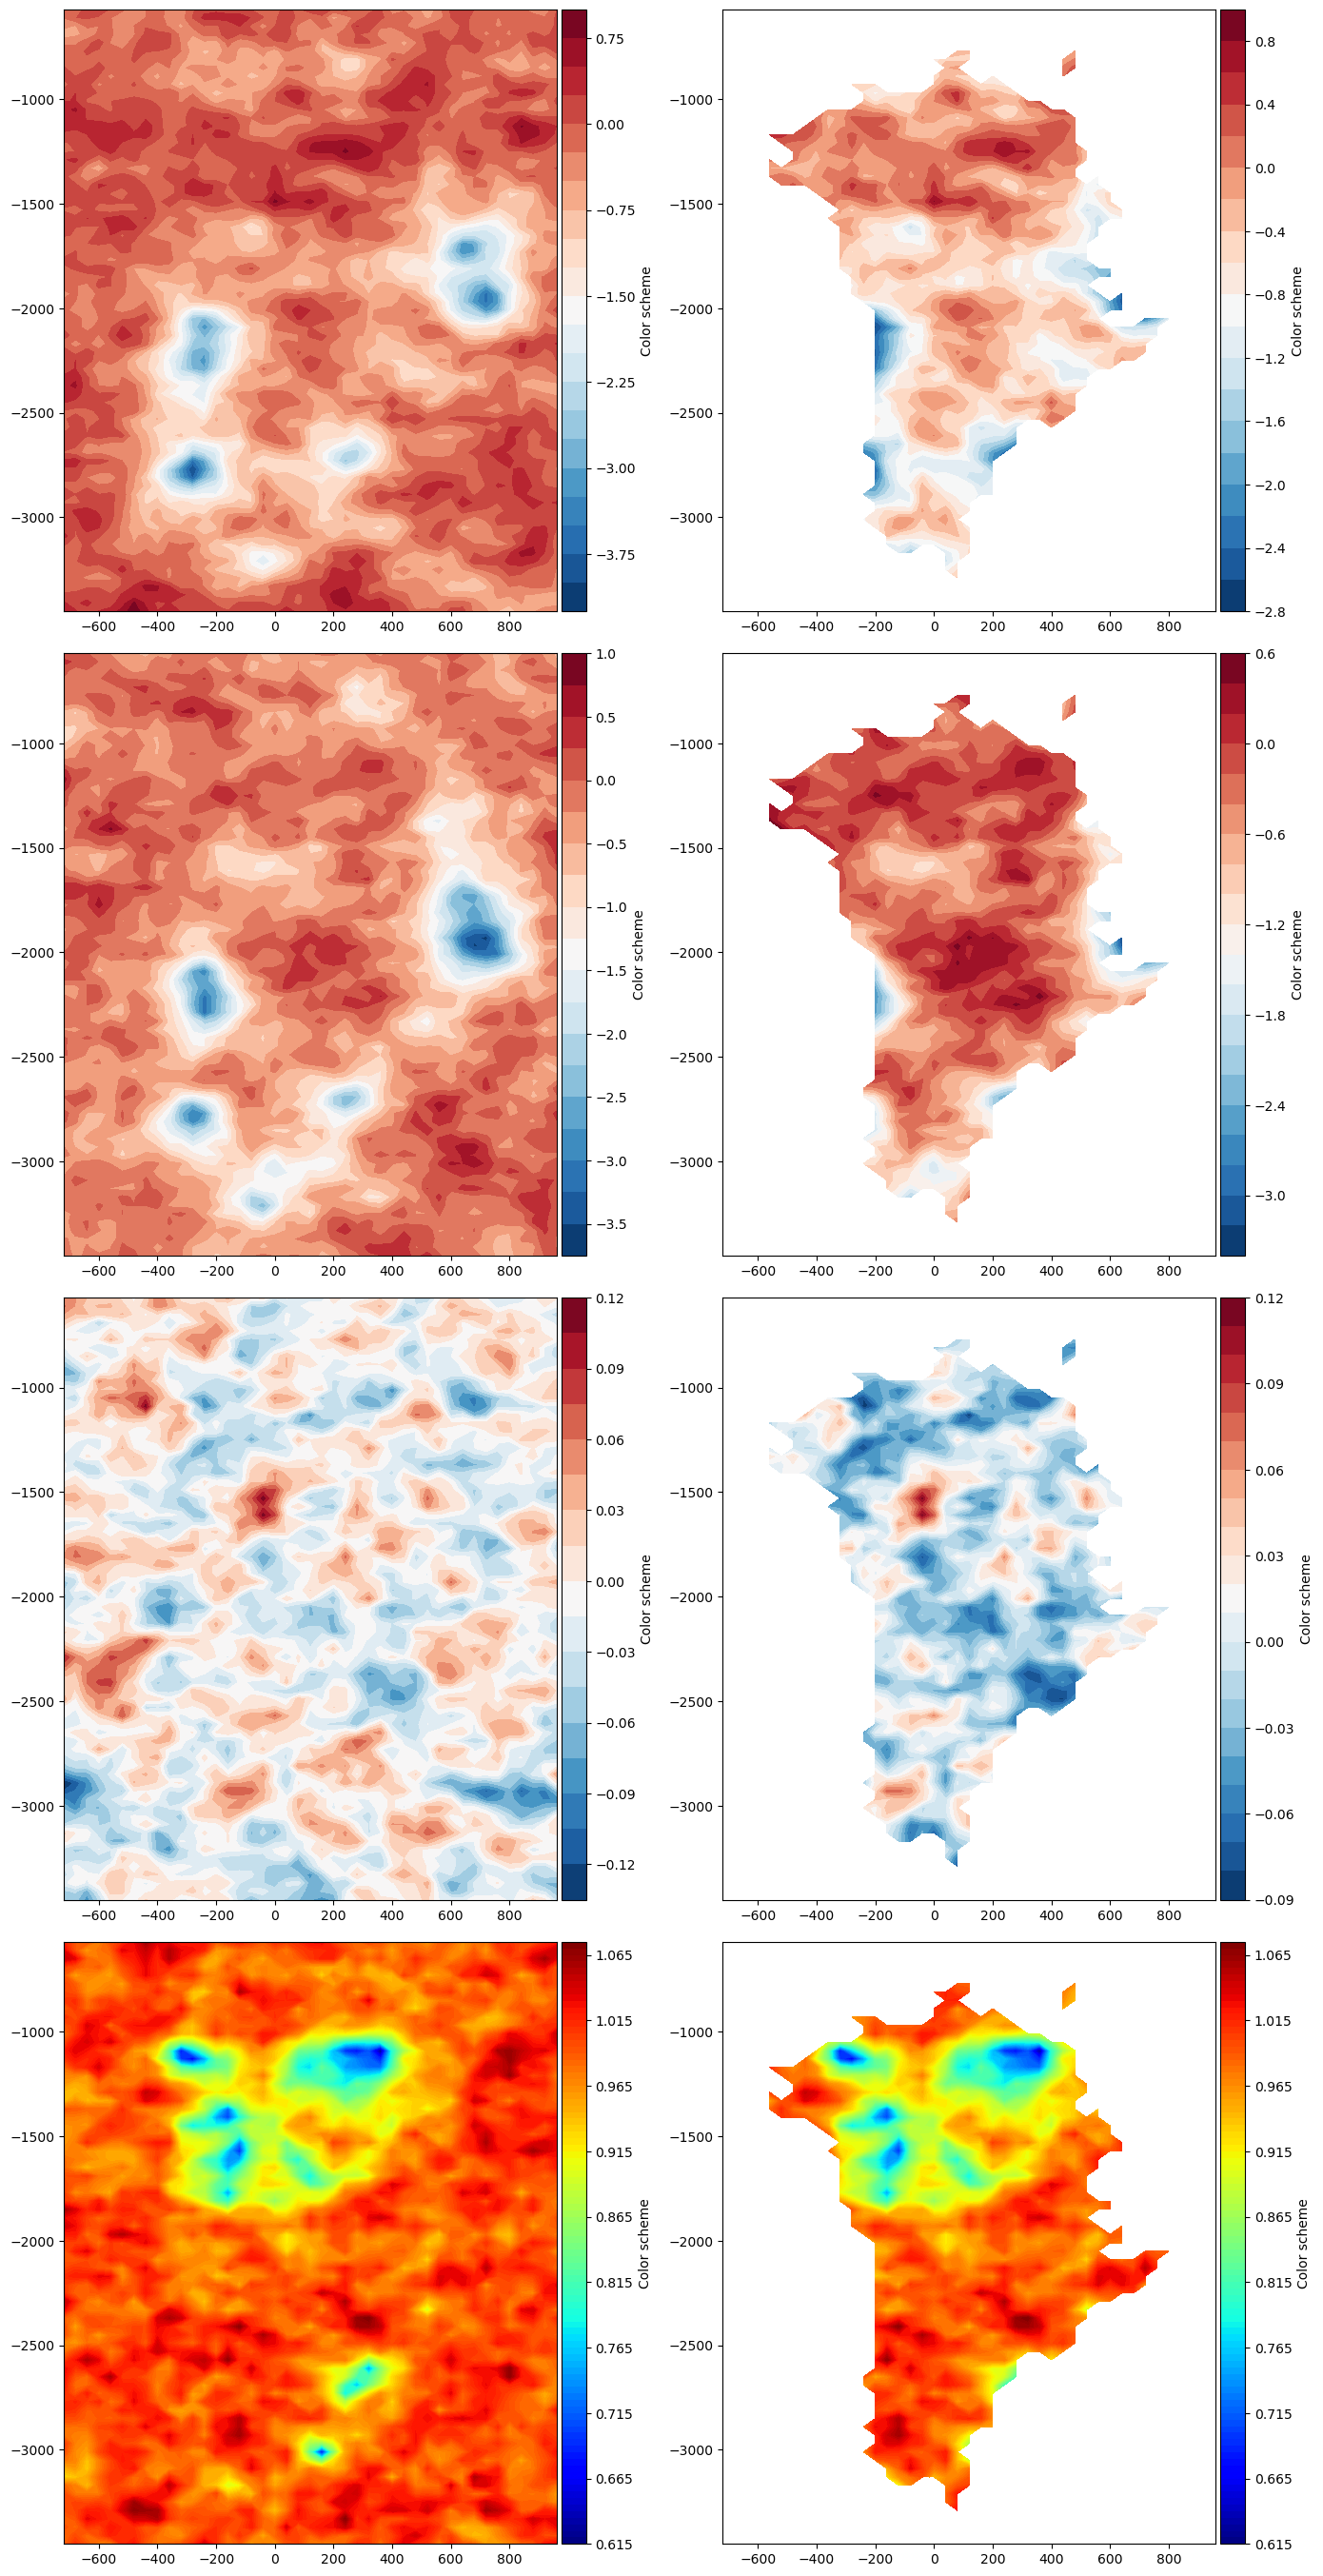

In [30]:
ds_subset_sample_posterior_1 = DA.sample_posterior(U_misfit_sa, Lambda_misfit_sa)
ds_subset_sample_posterior_2 = DA.sample_posterior(U_misfit_sa, Lambda_misfit_sa)
ds_mean_samples_posterior, ds_std_samples_posterior = DA.pointwise_marginals("posterior", 1000, U_misfit_sa, Lambda_misfit_sa)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [31]:
ds_std_samples_prior

<xarray.Dataset> Size: 51kB
Dimensions:                         (y: 73, x: 43, scalar: 1)
Coordinates:
  * y                               (y) float64 584B -3.45e+03 ... -570.0
  * x                               (x) float64 344B -720.0 -680.0 ... 960.0
Dimensions without coordinates: scalar
Data variables:
    xx_c_slide_initd                (y, x) float64 25kB 0.2981 0.2932 ... 0.3042
    xx_q_geod                       (y, x) float64 25kB 0.3036 0.3075 ... 0.2988
    xx_p_weertd                     (scalar) float64 8B 0.01012
    xx_q_weertd                     (scalar) float64 8B 0.01023
    xx_enh_fact_da_dummy2d_scalard  (scalar) float64 8B 0.01004
    xx_enh_intg_da_dummy2d_scalard  (scalar) float64 8B 0.00998
    xx_n_glen_da_dummy2d_scalard    (scalar) float64 8B 0.009953

In [32]:
ds_std_samples_posterior

<xarray.Dataset> Size: 51kB
Dimensions:                         (y: 73, x: 43, scalar: 1)
Coordinates:
  * y                               (y) float64 584B -3.45e+03 ... -570.0
  * x                               (x) float64 344B -720.0 -680.0 ... 960.0
Dimensions without coordinates: scalar
Data variables:
    xx_c_slide_initd                (y, x) float64 25kB 0.293 0.2957 ... 0.3098
    xx_q_geod                       (y, x) float64 25kB 0.3004 0.3074 ... 0.3051
    xx_p_weertd                     (scalar) float64 8B 0.009559
    xx_q_weertd                     (scalar) float64 8B 0.009869
    xx_enh_fact_da_dummy2d_scalard  (scalar) float64 8B 0.00694
    xx_enh_intg_da_dummy2d_scalard  (scalar) float64 8B 0.008907
    xx_n_glen_da_dummy2d_scalard    (scalar) float64 8B 0.00723

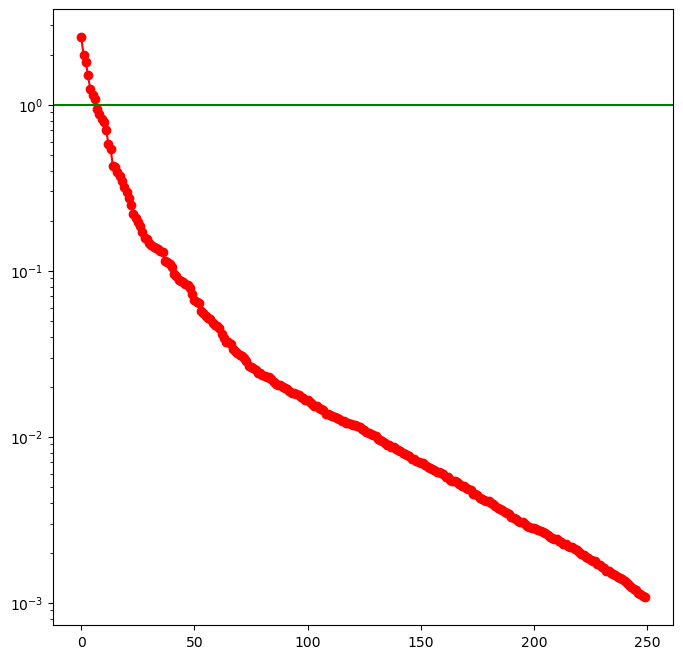

In [33]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color="red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color="red")

plt.axhline(1, color="green")

plt.yscale("log")

In [34]:
# DA = optim.DataAssimilation(sicopolis_dir, simulation,
#                             dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
#                             dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
#                             dict_og_params_fields_vals, dict_prior_params_fields_vals, dict_params_fields_num_dims, 
#                             dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
#                             dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
#                             MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini_exact_gamma_delta", None, ds_prior_X)

# DA.l_bfgs(5, 3)